In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc
import glob
import os
import csv

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers
from keras.models import load_model
%matplotlib inline

C:\Users\asus\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
SET50 = ['ADVANC', 'AOT', 'BANPU', 'BBL', 'BCP', 'BDMS',
        'BEM', 'BH', 'BJC', 'BTS', 'CENTEL', 'CPALL', 
         'CPF', 'CPN', 'DTAC', 'EGCO', 'HMPRO', 
         'INTUCH', 'IRPC', 'KBANK', 'KCE', 'KKP', 'KTB', 'LH', 'MINT', 'PTT',
        'PTTEP', 'ROBINS', 'SCB', 'SCC', 
        'TCAP', 'TISCO', 'TMB', 'TOP', 'TRUE', 'TU']

In [148]:
def load_stock_data(symbol, year_start, year_end):
    stock_data = []
    with open('../Data set/FIXED_SET50/' + symbol + '.BK.csv', 'r') as csv_file:
        file_data = csv.reader(csv_file, delimiter=',')
        file_data = list(file_data)[1:]
        for row in file_data:
            if row[1] is '':
                continue
            elif int(row[0][0:4]) >= year_start and int(row[0][0:4]) <= year_end:
                stock_data.append([float(row[1])])
                
    return stock_data

def mean_square_error(actual, predict):
    length = len(actual)
    sums_error = 0.0
    for i, j in zip(actual, predict):
        sums_error += (i - j)**2
    
    return sums_error / length

def findNewXTest(x_test, predict):
    for (index, element) in enumerate(x_test[0]):
        for i in range(len(element)):
            if i == 0:
                continue
            elif i < 29:
                element[i - 1] = element[i]
            else:
                element[i - 1] = element[i]
                element[i] = "{0:.4f}".format(predict[index])
    return x_test

In [149]:
stock_datas = [ load_stock_data(x, 2008, 2017) for x in SET50 ]

min_count = len(stock_datas[0])

In [150]:
scaler = MinMaxScaler(feature_range=(0, 1))
for (index, element) in enumerate (stock_datas):
    stock_datas[index] = scaler.fit_transform(stock_datas[index])

In [151]:
rounds = min_count - 30
train_index = int(rounds * 0.75)
validate_index = train_index + int(rounds * 0.05)

In [152]:
data = []
count = 0
index = 0
while index < rounds:
    temp = [i[index : index + 30] for i in stock_datas]
    data.append(temp)
    index += 1
    
x = np.asarray(data)
x_train = x[0: train_index].astype('float32')
x_validate = x[train_index: validate_index].astype('float32')
x_test = x[validate_index: validate_index+1].astype('float32')

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2] * x_train.shape[3]))
x_validate = np.reshape(x_validate, (x_validate.shape[0], x_validate.shape[1], x_validate.shape[2] * x_validate.shape[3]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2] * x_test.shape[3]))

# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[2] * x_train.shape[3], x_train.shape[1]))
# x_validate = np.reshape(x_validate, (x_validate.shape[0], x_validate.shape[2] * x_validate.shape[3],x_validate.shape[1]))
# x_test = np.reshape(x_test, (x_test.shape[0] , x_test.shape[2] * x_test.shape[3] , x_test.shape[1]))

print(x_train.shape, x_validate.shape, x_test.shape)

(1811, 36, 30) (120, 36, 30) (1, 36, 30)


In [153]:
target = []
index = 0
while index < rounds:
    temp = [stock_datas[i][index + 30][0] for i in range(len(stock_datas))]
    target.append(temp)
    index += 1
    
y = np.asarray(target)
y_train = y[0: train_index].astype('float32')
y_validate = y[train_index: validate_index].astype('float32')
y_test = y[validate_index: rounds].astype('float32')

print(y_train.shape, y_validate.shape, y_test.shape)

(1811, 36) (120, 36) (484, 36)


In [41]:
neurons = 512        
activation_function = 'tanh'  
loss = 'mse'                  
optimizer = 'adam'          
dropout = 0.25                
batch_size = 128       
epochs = 1000           
# window_len = 30                     

In [42]:
def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['acc','mse'])
    model.summary()
    return model

In [43]:
model = build_model(x_train, output_size=36, neurons=neurons)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 36, 512)           1112064   
_________________________________________________________________
dropout_7 (Dropout)          (None, 36, 512)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 36, 512)           2099200   
_________________________________________________________________
dropout_8 (Dropout)          (None, 36, 512)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 36)                18468     
__________

In [44]:
# model_history = model.fit(x_train, y_train, validation_data = (x_validate, y_validate), epochs = epochs, batch_size = batch_size, verbose= 1)
# model.save('LSTM_normalize_512_128_5000.h5')
# model = load_model('LSTM_512_128_10000.h5')

Train on 1811 samples, validate on 120 samples
Epoch 1/1000
1811/1811 [==============================] - 9s 5ms/step - loss: 0.0524 - acc: 0.1728 - mean_squared_error: 0.0524 - val_loss: 0.0498 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0498
Epoch 2/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 0.0160 - acc: 0.1822 - mean_squared_error: 0.0160 - val_loss: 0.0486 - val_acc: 0.0250 - val_mean_squared_error: 0.0486
Epoch 3/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 0.0115 - acc: 0.2833 - mean_squared_error: 0.0115 - val_loss: 0.0356 - val_acc: 0.0917 - val_mean_squared_error: 0.0356
Epoch 4/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 0.0101 - acc: 0.2938 - mean_squared_error: 0.0101 - val_loss: 0.0361 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0361
Epoch 5/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 0.0095 - acc: 0.2998 - mean_squared_error: 0.0095 - val_loss: 0.0335 - val_

Epoch 42/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 0.0021 - acc: 0.6295 - mean_squared_error: 0.0021 - val_loss: 0.0135 - val_acc: 0.7000 - val_mean_squared_error: 0.0135
Epoch 43/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 0.0021 - acc: 0.6345 - mean_squared_error: 0.0021 - val_loss: 0.0104 - val_acc: 0.7000 - val_mean_squared_error: 0.0104
Epoch 44/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 0.0020 - acc: 0.6499 - mean_squared_error: 0.0020 - val_loss: 0.0113 - val_acc: 0.7000 - val_mean_squared_error: 0.0113
Epoch 45/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 0.0019 - acc: 0.6322 - mean_squared_error: 0.0019 - val_loss: 0.0107 - val_acc: 0.7000 - val_mean_squared_error: 0.0107
Epoch 46/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 0.0019 - acc: 0.6389 - mean_squared_error: 0.0019 - val_loss: 0.0106 - val_acc: 0.7000 - val_mean_squared_error: 0.0106
Epoch

1811/1811 [==============================] - 6s 4ms/step - loss: 0.0012 - acc: 0.7366 - mean_squared_error: 0.0012 - val_loss: 0.0127 - val_acc: 0.7000 - val_mean_squared_error: 0.0127
Epoch 84/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 0.0012 - acc: 0.7327 - mean_squared_error: 0.0012 - val_loss: 0.0115 - val_acc: 0.7000 - val_mean_squared_error: 0.0115
Epoch 85/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 0.0011 - acc: 0.7421 - mean_squared_error: 0.0011 - val_loss: 0.0115 - val_acc: 0.7000 - val_mean_squared_error: 0.0115
Epoch 86/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 0.0011 - acc: 0.7465 - mean_squared_error: 0.0011 - val_loss: 0.0120 - val_acc: 0.7000 - val_mean_squared_error: 0.0120
Epoch 87/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 0.0011 - acc: 0.7510 - mean_squared_error: 0.0011 - val_loss: 0.0114 - val_acc: 0.7000 - val_mean_squared_error: 0.0114
Epoch 88/1000
1811/

1811/1811 [==============================] - 7s 4ms/step - loss: 8.9607e-04 - acc: 0.7802 - mean_squared_error: 8.9607e-04 - val_loss: 0.0095 - val_acc: 0.7000 - val_mean_squared_error: 0.0095
Epoch 124/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.6707e-04 - acc: 0.7797 - mean_squared_error: 8.6707e-04 - val_loss: 0.0096 - val_acc: 0.7000 - val_mean_squared_error: 0.0096
Epoch 125/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.4417e-04 - acc: 0.7764 - mean_squared_error: 8.4417e-04 - val_loss: 0.0085 - val_acc: 0.7000 - val_mean_squared_error: 0.0085
Epoch 126/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 9.0883e-04 - acc: 0.7769 - mean_squared_error: 9.0883e-04 - val_loss: 0.0098 - val_acc: 0.7000 - val_mean_squared_error: 0.0098
Epoch 127/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 0.0010 - acc: 0.7703 - mean_squared_error: 0.0010 - val_loss: 0.0088 - val_acc: 0.7000 - val_mean_squar

1811/1811 [==============================] - 7s 4ms/step - loss: 7.3425e-04 - acc: 0.7802 - mean_squared_error: 7.3425e-04 - val_loss: 0.0093 - val_acc: 0.7000 - val_mean_squared_error: 0.0093
Epoch 163/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.5770e-04 - acc: 0.7913 - mean_squared_error: 7.5770e-04 - val_loss: 0.0091 - val_acc: 0.6500 - val_mean_squared_error: 0.0091
Epoch 164/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.5642e-04 - acc: 0.7880 - mean_squared_error: 7.5642e-04 - val_loss: 0.0091 - val_acc: 0.7000 - val_mean_squared_error: 0.0091
Epoch 165/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.3693e-04 - acc: 0.7891 - mean_squared_error: 7.3693e-04 - val_loss: 0.0095 - val_acc: 0.7000 - val_mean_squared_error: 0.0095
Epoch 166/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.3935e-04 - acc: 0.7896 - mean_squared_error: 7.3935e-04 - val_loss: 0.0084 - val_acc: 0.7000 - val_me

1811/1811 [==============================] - 7s 4ms/step - loss: 7.0429e-04 - acc: 0.8018 - mean_squared_error: 7.0429e-04 - val_loss: 0.0083 - val_acc: 0.7000 - val_mean_squared_error: 0.0083
Epoch 202/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.3233e-04 - acc: 0.7913 - mean_squared_error: 7.3233e-04 - val_loss: 0.0092 - val_acc: 0.7000 - val_mean_squared_error: 0.0092
Epoch 203/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.9863e-04 - acc: 0.8012 - mean_squared_error: 6.9863e-04 - val_loss: 0.0095 - val_acc: 0.7000 - val_mean_squared_error: 0.0095
Epoch 204/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.9654e-04 - acc: 0.8128 - mean_squared_error: 6.9654e-04 - val_loss: 0.0092 - val_acc: 0.7000 - val_mean_squared_error: 0.0092
Epoch 205/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.7542e-04 - acc: 0.7968 - mean_squared_error: 6.7542e-04 - val_loss: 0.0105 - val_acc: 0.7000 - val_me

1811/1811 [==============================] - 7s 4ms/step - loss: 6.4710e-04 - acc: 0.8134 - mean_squared_error: 6.4710e-04 - val_loss: 0.0097 - val_acc: 0.6667 - val_mean_squared_error: 0.0097
Epoch 241/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.6980e-04 - acc: 0.8106 - mean_squared_error: 6.6980e-04 - val_loss: 0.0088 - val_acc: 0.7000 - val_mean_squared_error: 0.0088
Epoch 242/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 6.7466e-04 - acc: 0.7880 - mean_squared_error: 6.7466e-04 - val_loss: 0.0103 - val_acc: 0.7000 - val_mean_squared_error: 0.0103
Epoch 243/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.4201e-04 - acc: 0.8106 - mean_squared_error: 6.4201e-04 - val_loss: 0.0090 - val_acc: 0.7000 - val_mean_squared_error: 0.0090
Epoch 244/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 6.0260e-04 - acc: 0.8040 - mean_squared_error: 6.0260e-04 - val_loss: 0.0099 - val_acc: 0.7000 - val_me

1811/1811 [==============================] - 7s 4ms/step - loss: 5.6581e-04 - acc: 0.8205 - mean_squared_error: 5.6581e-04 - val_loss: 0.0100 - val_acc: 0.5083 - val_mean_squared_error: 0.0100
Epoch 280/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.0558e-04 - acc: 0.8128 - mean_squared_error: 6.0558e-04 - val_loss: 0.0101 - val_acc: 0.7000 - val_mean_squared_error: 0.0101
Epoch 281/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.8443e-04 - acc: 0.8167 - mean_squared_error: 5.8443e-04 - val_loss: 0.0105 - val_acc: 0.5583 - val_mean_squared_error: 0.0105
Epoch 282/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.8144e-04 - acc: 0.8073 - mean_squared_error: 5.8144e-04 - val_loss: 0.0093 - val_acc: 0.7000 - val_mean_squared_error: 0.0093
Epoch 283/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.5849e-04 - acc: 0.8150 - mean_squared_error: 6.5849e-04 - val_loss: 0.0092 - val_acc: 0.7000 - val_me

1811/1811 [==============================] - 7s 4ms/step - loss: 5.1532e-04 - acc: 0.8089 - mean_squared_error: 5.1532e-04 - val_loss: 0.0107 - val_acc: 0.6583 - val_mean_squared_error: 0.0107
Epoch 319/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 5.0573e-04 - acc: 0.8338 - mean_squared_error: 5.0573e-04 - val_loss: 0.0093 - val_acc: 0.7000 - val_mean_squared_error: 0.0093
Epoch 320/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3269e-04 - acc: 0.8200 - mean_squared_error: 5.3269e-04 - val_loss: 0.0089 - val_acc: 0.7000 - val_mean_squared_error: 0.0089
Epoch 321/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.9310e-04 - acc: 0.8128 - mean_squared_error: 5.9310e-04 - val_loss: 0.0103 - val_acc: 0.6667 - val_mean_squared_error: 0.0103
Epoch 322/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.7151e-04 - acc: 0.8167 - mean_squared_error: 5.7151e-04 - val_loss: 0.0103 - val_acc: 0.7000 - val_me

1811/1811 [==============================] - 7s 4ms/step - loss: 4.7990e-04 - acc: 0.8178 - mean_squared_error: 4.7990e-04 - val_loss: 0.0106 - val_acc: 0.7000 - val_mean_squared_error: 0.0106
Epoch 358/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0779e-04 - acc: 0.8222 - mean_squared_error: 5.0779e-04 - val_loss: 0.0092 - val_acc: 0.7000 - val_mean_squared_error: 0.0092
Epoch 359/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7455e-04 - acc: 0.8117 - mean_squared_error: 4.7455e-04 - val_loss: 0.0109 - val_acc: 0.7000 - val_mean_squared_error: 0.0109
Epoch 360/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1437e-04 - acc: 0.8261 - mean_squared_error: 5.1437e-04 - val_loss: 0.0098 - val_acc: 0.7000 - val_mean_squared_error: 0.0098
Epoch 361/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.1387e-04 - acc: 0.8266 - mean_squared_error: 5.1387e-04 - val_loss: 0.0101 - val_acc: 0.7000 - val_me

1811/1811 [==============================] - 7s 4ms/step - loss: 5.0167e-04 - acc: 0.8277 - mean_squared_error: 5.0167e-04 - val_loss: 0.0105 - val_acc: 0.7000 - val_mean_squared_error: 0.0105
Epoch 397/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.3312e-04 - acc: 0.8194 - mean_squared_error: 5.3312e-04 - val_loss: 0.0094 - val_acc: 0.7000 - val_mean_squared_error: 0.0094
Epoch 398/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.0946e-04 - acc: 0.8222 - mean_squared_error: 5.0946e-04 - val_loss: 0.0097 - val_acc: 0.6583 - val_mean_squared_error: 0.0097
Epoch 399/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.8376e-04 - acc: 0.8393 - mean_squared_error: 4.8376e-04 - val_loss: 0.0107 - val_acc: 0.7000 - val_mean_squared_error: 0.0107
Epoch 400/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.6561e-04 - acc: 0.8355 - mean_squared_error: 4.6561e-04 - val_loss: 0.0101 - val_acc: 0.7000 - val_me

1811/1811 [==============================] - 7s 4ms/step - loss: 4.7399e-04 - acc: 0.8250 - mean_squared_error: 4.7399e-04 - val_loss: 0.0101 - val_acc: 0.7000 - val_mean_squared_error: 0.0101
Epoch 436/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9146e-04 - acc: 0.8366 - mean_squared_error: 4.9146e-04 - val_loss: 0.0095 - val_acc: 0.7000 - val_mean_squared_error: 0.0095
Epoch 437/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 4.2658e-04 - acc: 0.8448 - mean_squared_error: 4.2658e-04 - val_loss: 0.0116 - val_acc: 0.5667 - val_mean_squared_error: 0.0116
Epoch 438/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.9787e-04 - acc: 0.8277 - mean_squared_error: 4.9787e-04 - val_loss: 0.0092 - val_acc: 0.7000 - val_mean_squared_error: 0.0092
Epoch 439/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 4.7634e-04 - acc: 0.8310 - mean_squared_error: 4.7634e-04 - val_loss: 0.0097 - val_acc: 0.6917 - val_me

1811/1811 [==============================] - 6s 4ms/step - loss: 0.0020 - acc: 0.6168 - mean_squared_error: 0.0020 - val_loss: 0.0307 - val_acc: 0.6167 - val_mean_squared_error: 0.0307
Epoch 476/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 0.0019 - acc: 0.6146 - mean_squared_error: 0.0019 - val_loss: 0.0295 - val_acc: 0.2583 - val_mean_squared_error: 0.0295
Epoch 477/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 0.0019 - acc: 0.6234 - mean_squared_error: 0.0019 - val_loss: 0.0310 - val_acc: 0.2583 - val_mean_squared_error: 0.0310
Epoch 478/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 0.0019 - acc: 0.6378 - mean_squared_error: 0.0019 - val_loss: 0.0333 - val_acc: 0.2500 - val_mean_squared_error: 0.0333
Epoch 479/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 0.0019 - acc: 0.6350 - mean_squared_error: 0.0019 - val_loss: 0.0306 - val_acc: 0.2917 - val_mean_squared_error: 0.0306
Epoch 480/1000


1811/1811 [==============================] - 7s 4ms/step - loss: 0.0014 - acc: 0.6759 - mean_squared_error: 0.0014 - val_loss: 0.0319 - val_acc: 0.3417 - val_mean_squared_error: 0.0319
Epoch 517/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 0.0014 - acc: 0.7073 - mean_squared_error: 0.0014 - val_loss: 0.0305 - val_acc: 0.4583 - val_mean_squared_error: 0.0305
Epoch 518/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 0.0014 - acc: 0.7013 - mean_squared_error: 0.0014 - val_loss: 0.0299 - val_acc: 0.4583 - val_mean_squared_error: 0.0299
Epoch 519/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 0.0014 - acc: 0.6891 - mean_squared_error: 0.0014 - val_loss: 0.0321 - val_acc: 0.4333 - val_mean_squared_error: 0.0321
Epoch 520/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 0.0013 - acc: 0.7140 - mean_squared_error: 0.0013 - val_loss: 0.0304 - val_acc: 0.4667 - val_mean_squared_error: 0.0304
Epoch 521/1000


1811/1811 [==============================] - 6s 4ms/step - loss: 0.0011 - acc: 0.7311 - mean_squared_error: 0.0011 - val_loss: 0.0277 - val_acc: 0.5500 - val_mean_squared_error: 0.0277
Epoch 558/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 0.0011 - acc: 0.7200 - mean_squared_error: 0.0011 - val_loss: 0.0240 - val_acc: 0.4250 - val_mean_squared_error: 0.0240
Epoch 559/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 0.0011 - acc: 0.7294 - mean_squared_error: 0.0011 - val_loss: 0.0286 - val_acc: 0.5000 - val_mean_squared_error: 0.0286
Epoch 560/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 0.0011 - acc: 0.7460 - mean_squared_error: 0.0011 - val_loss: 0.0304 - val_acc: 0.5250 - val_mean_squared_error: 0.0304
Epoch 561/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 0.0011 - acc: 0.7289 - mean_squared_error: 0.0011 - val_loss: 0.0291 - val_acc: 0.5250 - val_mean_squared_error: 0.0291
Epoch 562/1000


Epoch 598/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 9.8706e-04 - acc: 0.7532 - mean_squared_error: 9.8706e-04 - val_loss: 0.0292 - val_acc: 0.5500 - val_mean_squared_error: 0.0292
Epoch 599/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 0.0010 - acc: 0.7620 - mean_squared_error: 0.0010 - val_loss: 0.0252 - val_acc: 0.2833 - val_mean_squared_error: 0.0252
Epoch 600/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 0.0010 - acc: 0.7631 - mean_squared_error: 0.0010 - val_loss: 0.0257 - val_acc: 0.3917 - val_mean_squared_error: 0.0257
Epoch 601/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 9.8393e-04 - acc: 0.7493 - mean_squared_error: 9.8393e-04 - val_loss: 0.0274 - val_acc: 0.4083 - val_mean_squared_error: 0.0274
Epoch 602/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 9.9628e-04 - acc: 0.7532 - mean_squared_error: 9.9628e-04 - val_loss: 0.0252 - val_acc: 0.4333 - val_mea

1811/1811 [==============================] - 6s 4ms/step - loss: 9.1267e-04 - acc: 0.7598 - mean_squared_error: 9.1267e-04 - val_loss: 0.0280 - val_acc: 0.2667 - val_mean_squared_error: 0.0280
Epoch 638/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 9.4769e-04 - acc: 0.7615 - mean_squared_error: 9.4769e-04 - val_loss: 0.0262 - val_acc: 0.2417 - val_mean_squared_error: 0.0262
Epoch 639/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 9.9193e-04 - acc: 0.7504 - mean_squared_error: 9.9193e-04 - val_loss: 0.0255 - val_acc: 0.2833 - val_mean_squared_error: 0.0255
Epoch 640/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 9.2164e-04 - acc: 0.7471 - mean_squared_error: 9.2164e-04 - val_loss: 0.0225 - val_acc: 0.3917 - val_mean_squared_error: 0.0225
Epoch 641/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 9.5191e-04 - acc: 0.7642 - mean_squared_error: 9.5191e-04 - val_loss: 0.0215 - val_acc: 0.3917 - val_me

1811/1811 [==============================] - 6s 4ms/step - loss: 9.5462e-04 - acc: 0.7615 - mean_squared_error: 9.5462e-04 - val_loss: 0.0282 - val_acc: 0.3833 - val_mean_squared_error: 0.0282
Epoch 677/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.6064e-04 - acc: 0.7697 - mean_squared_error: 8.6064e-04 - val_loss: 0.0248 - val_acc: 0.3833 - val_mean_squared_error: 0.0248
Epoch 678/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.4378e-04 - acc: 0.7874 - mean_squared_error: 8.4378e-04 - val_loss: 0.0242 - val_acc: 0.3667 - val_mean_squared_error: 0.0242
Epoch 679/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 9.2058e-04 - acc: 0.7653 - mean_squared_error: 9.2058e-04 - val_loss: 0.0241 - val_acc: 0.3667 - val_mean_squared_error: 0.0241
Epoch 680/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 8.7895e-04 - acc: 0.7587 - mean_squared_error: 8.7895e-04 - val_loss: 0.0238 - val_acc: 0.2500 - val_me

1811/1811 [==============================] - 6s 4ms/step - loss: 8.2259e-04 - acc: 0.7725 - mean_squared_error: 8.2259e-04 - val_loss: 0.0274 - val_acc: 0.3583 - val_mean_squared_error: 0.0274
Epoch 716/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 7.9212e-04 - acc: 0.7802 - mean_squared_error: 7.9212e-04 - val_loss: 0.0264 - val_acc: 0.3417 - val_mean_squared_error: 0.0264
Epoch 717/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 7.8548e-04 - acc: 0.7708 - mean_squared_error: 7.8548e-04 - val_loss: 0.0255 - val_acc: 0.3333 - val_mean_squared_error: 0.0255
Epoch 718/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 8.1638e-04 - acc: 0.7797 - mean_squared_error: 8.1638e-04 - val_loss: 0.0238 - val_acc: 0.2917 - val_mean_squared_error: 0.0238
Epoch 719/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 8.5583e-04 - acc: 0.7786 - mean_squared_error: 8.5583e-04 - val_loss: 0.0276 - val_acc: 0.3417 - val_me

1811/1811 [==============================] - 7s 4ms/step - loss: 7.6081e-04 - acc: 0.7869 - mean_squared_error: 7.6081e-04 - val_loss: 0.0233 - val_acc: 0.3500 - val_mean_squared_error: 0.0233
Epoch 755/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.6338e-04 - acc: 0.7902 - mean_squared_error: 7.6338e-04 - val_loss: 0.0266 - val_acc: 0.3500 - val_mean_squared_error: 0.0266
Epoch 756/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.8526e-04 - acc: 0.7924 - mean_squared_error: 7.8526e-04 - val_loss: 0.0263 - val_acc: 0.3500 - val_mean_squared_error: 0.0263
Epoch 757/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.8852e-04 - acc: 0.7973 - mean_squared_error: 7.8852e-04 - val_loss: 0.0280 - val_acc: 0.3833 - val_mean_squared_error: 0.0280
Epoch 758/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.8275e-04 - acc: 0.7946 - mean_squared_error: 7.8275e-04 - val_loss: 0.0288 - val_acc: 0.3500 - val_me

1811/1811 [==============================] - 7s 4ms/step - loss: 7.3616e-04 - acc: 0.7885 - mean_squared_error: 7.3616e-04 - val_loss: 0.0278 - val_acc: 0.1917 - val_mean_squared_error: 0.0278
Epoch 794/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.9942e-04 - acc: 0.7979 - mean_squared_error: 6.9942e-04 - val_loss: 0.0279 - val_acc: 0.2083 - val_mean_squared_error: 0.0279
Epoch 795/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 6.8047e-04 - acc: 0.8067 - mean_squared_error: 6.8047e-04 - val_loss: 0.0266 - val_acc: 0.2000 - val_mean_squared_error: 0.0266
Epoch 796/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 7.1204e-04 - acc: 0.8045 - mean_squared_error: 7.1204e-04 - val_loss: 0.0287 - val_acc: 0.1917 - val_mean_squared_error: 0.0287
Epoch 797/1000
1811/1811 [==============================] - 6s 4ms/step - loss: 6.9105e-04 - acc: 0.7985 - mean_squared_error: 6.9105e-04 - val_loss: 0.0284 - val_acc: 0.2250 - val_me

1811/1811 [==============================] - 7s 4ms/step - loss: 7.1334e-04 - acc: 0.7835 - mean_squared_error: 7.1334e-04 - val_loss: 0.0301 - val_acc: 0.3083 - val_mean_squared_error: 0.0301
Epoch 833/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.0932e-04 - acc: 0.8007 - mean_squared_error: 7.0932e-04 - val_loss: 0.0283 - val_acc: 0.2333 - val_mean_squared_error: 0.0283
Epoch 834/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.3112e-04 - acc: 0.7918 - mean_squared_error: 7.3112e-04 - val_loss: 0.0278 - val_acc: 0.2417 - val_mean_squared_error: 0.0278
Epoch 835/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.2731e-04 - acc: 0.7962 - mean_squared_error: 7.2731e-04 - val_loss: 0.0306 - val_acc: 0.1167 - val_mean_squared_error: 0.0306
Epoch 836/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 7.2778e-04 - acc: 0.8062 - mean_squared_error: 7.2778e-04 - val_loss: 0.0290 - val_acc: 0.1917 - val_me

1811/1811 [==============================] - 7s 4ms/step - loss: 6.4371e-04 - acc: 0.7951 - mean_squared_error: 6.4371e-04 - val_loss: 0.0301 - val_acc: 0.1917 - val_mean_squared_error: 0.0301
Epoch 872/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.5222e-04 - acc: 0.8095 - mean_squared_error: 6.5222e-04 - val_loss: 0.0282 - val_acc: 0.2083 - val_mean_squared_error: 0.0282
Epoch 873/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.5202e-04 - acc: 0.7946 - mean_squared_error: 6.5202e-04 - val_loss: 0.0271 - val_acc: 0.2167 - val_mean_squared_error: 0.0271
Epoch 874/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.3573e-04 - acc: 0.8128 - mean_squared_error: 6.3573e-04 - val_loss: 0.0302 - val_acc: 0.2000 - val_mean_squared_error: 0.0302
Epoch 875/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.6805e-04 - acc: 0.7990 - mean_squared_error: 6.6805e-04 - val_loss: 0.0298 - val_acc: 0.1917 - val_me

1811/1811 [==============================] - 7s 4ms/step - loss: 6.3829e-04 - acc: 0.7968 - mean_squared_error: 6.3829e-04 - val_loss: 0.0265 - val_acc: 0.2083 - val_mean_squared_error: 0.0265
Epoch 911/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.2392e-04 - acc: 0.8084 - mean_squared_error: 6.2392e-04 - val_loss: 0.0320 - val_acc: 0.1917 - val_mean_squared_error: 0.0320
Epoch 912/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.3588e-04 - acc: 0.8029 - mean_squared_error: 6.3588e-04 - val_loss: 0.0265 - val_acc: 0.1917 - val_mean_squared_error: 0.0265
Epoch 913/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.2510e-04 - acc: 0.8112 - mean_squared_error: 6.2510e-04 - val_loss: 0.0287 - val_acc: 0.1917 - val_mean_squared_error: 0.0287
Epoch 914/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.2242e-04 - acc: 0.8145 - mean_squared_error: 6.2242e-04 - val_loss: 0.0260 - val_acc: 0.1917 - val_me

1811/1811 [==============================] - 7s 4ms/step - loss: 5.9558e-04 - acc: 0.8078 - mean_squared_error: 5.9558e-04 - val_loss: 0.0277 - val_acc: 0.2000 - val_mean_squared_error: 0.0277
Epoch 950/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.1123e-04 - acc: 0.8106 - mean_squared_error: 6.1123e-04 - val_loss: 0.0272 - val_acc: 0.1917 - val_mean_squared_error: 0.0272
Epoch 951/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.3330e-04 - acc: 0.8056 - mean_squared_error: 6.3330e-04 - val_loss: 0.0343 - val_acc: 0.1917 - val_mean_squared_error: 0.0343
Epoch 952/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.4239e-04 - acc: 0.8106 - mean_squared_error: 6.4239e-04 - val_loss: 0.0244 - val_acc: 0.1917 - val_mean_squared_error: 0.0244
Epoch 953/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.9716e-04 - acc: 0.8156 - mean_squared_error: 5.9716e-04 - val_loss: 0.0274 - val_acc: 0.1917 - val_me

1811/1811 [==============================] - 6s 4ms/step - loss: 5.7625e-04 - acc: 0.8117 - mean_squared_error: 5.7625e-04 - val_loss: 0.0267 - val_acc: 0.1917 - val_mean_squared_error: 0.0267
Epoch 989/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.0077e-04 - acc: 0.8134 - mean_squared_error: 6.0077e-04 - val_loss: 0.0280 - val_acc: 0.1917 - val_mean_squared_error: 0.0280
Epoch 990/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.8868e-04 - acc: 0.8062 - mean_squared_error: 5.8868e-04 - val_loss: 0.0300 - val_acc: 0.2083 - val_mean_squared_error: 0.0300
Epoch 991/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 5.8099e-04 - acc: 0.8018 - mean_squared_error: 5.8099e-04 - val_loss: 0.0261 - val_acc: 0.1917 - val_mean_squared_error: 0.0261
Epoch 992/1000
1811/1811 [==============================] - 7s 4ms/step - loss: 6.2683e-04 - acc: 0.8012 - mean_squared_error: 6.2683e-04 - val_loss: 0.0300 - val_acc: 0.1917 - val_me

In [45]:
model.save('LSTM_normalize_512_128_1000.h5')

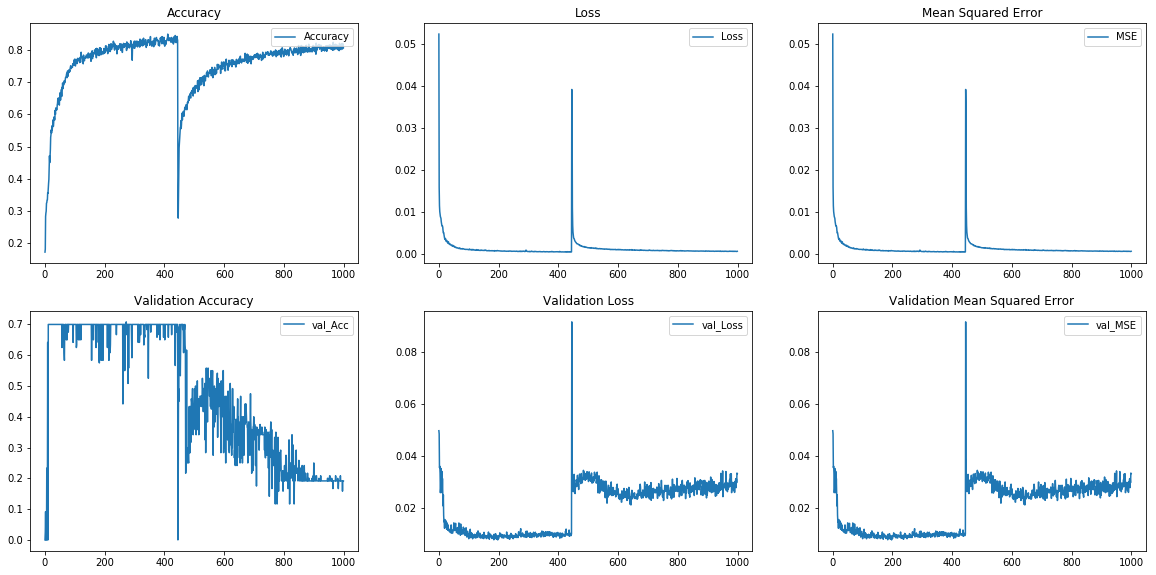

In [46]:
plt.figure(figsize=(20,15))
plt.subplot(331)
plt.plot(model_history.history['acc'] , label = 'Accuracy')
plt.legend(loc = 'upper right')
plt.title("Accuracy")

plt.subplot(332)
plt.plot(model_history.history['loss'] , label = 'Loss')
plt.legend(loc = 'upper right')
plt.title("Loss")

plt.subplot(333)
plt.plot(model_history.history['mean_squared_error'] , label = 'MSE')
plt.legend(loc = 'upper right')
plt.title("Mean Squared Error")

plt.subplot(334)
plt.plot(model_history.history['val_acc'] , label = 'val_Acc')
plt.legend(loc = 'upper right')
plt.title("Validation Accuracy")

plt.subplot(335)
plt.plot(model_history.history['val_loss'] , label = 'val_Loss')
plt.legend(loc = 'upper right')
plt.title("Validation Loss")

plt.subplot(336)
plt.plot(model_history.history['val_mean_squared_error'] , label = 'val_MSE')
plt.legend(loc = 'upper right')
plt.title("Validation Mean Squared Error")

plt.show()

In [12]:
# model = load_model('LSTM_512_128_10000.h5')

In [159]:
predicts = []
test_data = x_test.copy()
for (index, element) in enumerate(y_test):
    predict = model.predict(test_data, verbose = 0)
    predicts.append(predict[0])
    test_data = findNewXTest(test_data, predict[0])

In [160]:
predicts

[array([0.6607667 , 0.19386676, 0.7204193 , 0.791979  , 0.5651772 ,
        0.5230446 , 0.09918755, 0.30258253, 0.3552597 , 0.6739229 ,
        0.3487794 , 0.3408117 , 0.5810269 , 0.33673304, 0.2793194 ,
        0.37049323, 0.3823493 , 0.65797853, 0.8228783 , 0.7873311 ,
        0.16271082, 0.48453504, 0.7400224 , 0.73283494, 0.43363425,
        0.7461462 , 0.8020811 , 0.4690384 , 0.76310706, 0.8503199 ,
        0.6223651 , 0.45474225, 0.8415673 , 0.7272518 , 0.6131072 ,
        0.6495134 ], dtype=float32),
 array([0.5832912 , 0.15156932, 0.8116728 , 0.79866993, 0.4869179 ,
        0.4361535 , 0.08306514, 0.2522422 , 0.29221854, 0.6058637 ,
        0.2563732 , 0.29092947, 0.57591677, 0.2750498 , 0.24779662,
        0.31984675, 0.3251944 , 0.5856144 , 0.87003577, 0.7381729 ,
        0.12511294, 0.48106313, 0.7150084 , 0.6778915 , 0.35953796,
        0.7731482 , 0.8489229 , 0.40862224, 0.72423995, 0.8145721 ,
        0.62259364, 0.45452502, 0.8327702 , 0.77476126, 0.54960966,
        0.6

In [136]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [137]:
y_test = scaler.fit_transform(y_test)

TypeError: float() argument must be a string or a number, not 'MinMaxScaler'

In [114]:
y_test_denormalize = scaler.inverse_transform(y_test)

In [131]:
predicts_denormalize = scaler.inverse_transform(predicts)

(1, 36)

In [124]:
def plot_graph(array1, array4):
    plt.figure(figsize=(20,10))
    x_axis = [i for i in range(len(array1))]
    plt.plot(x_axis, array1, 'g')
    plt.plot(x_axis, array4, 'y')

    plt.show()
    
def get_data_from_nparray(nparray, index):
    return_data = [i[index] for i in nparray]
    return return_data

ADVANC


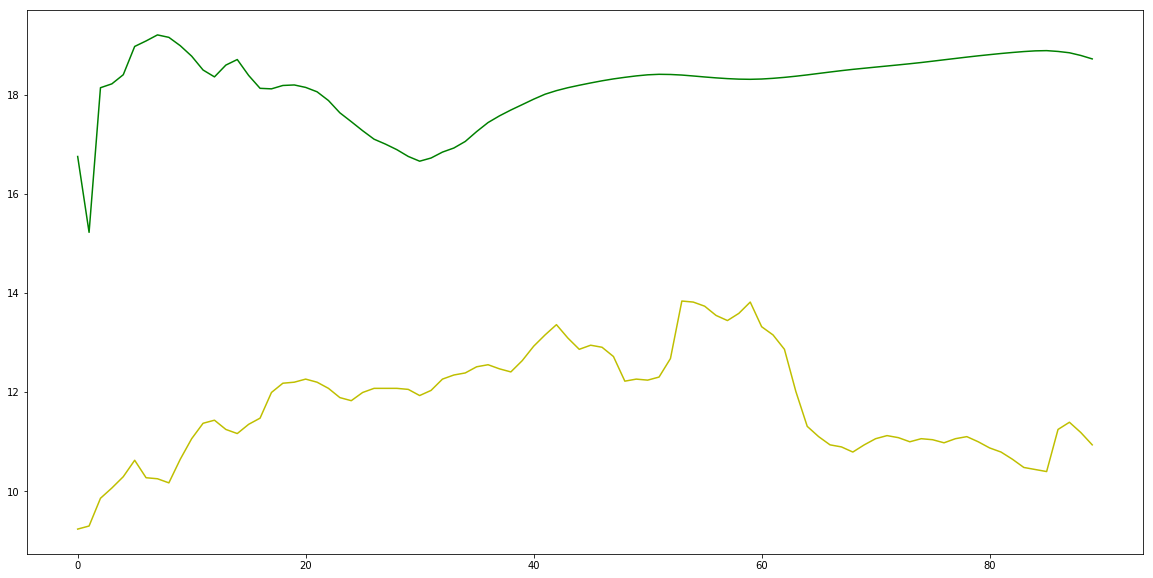

AOT


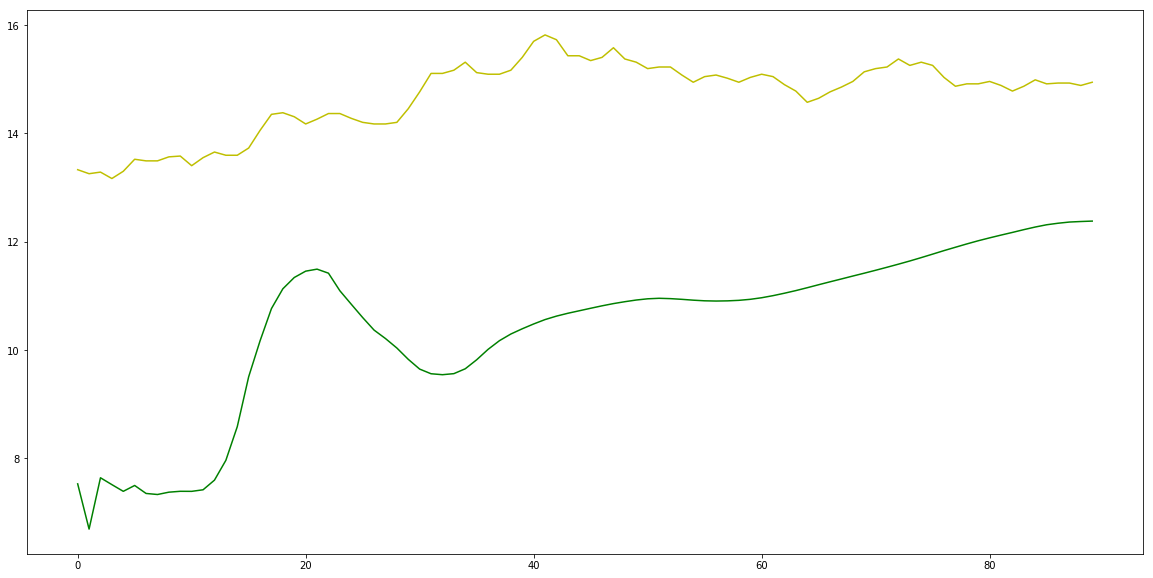

BANPU


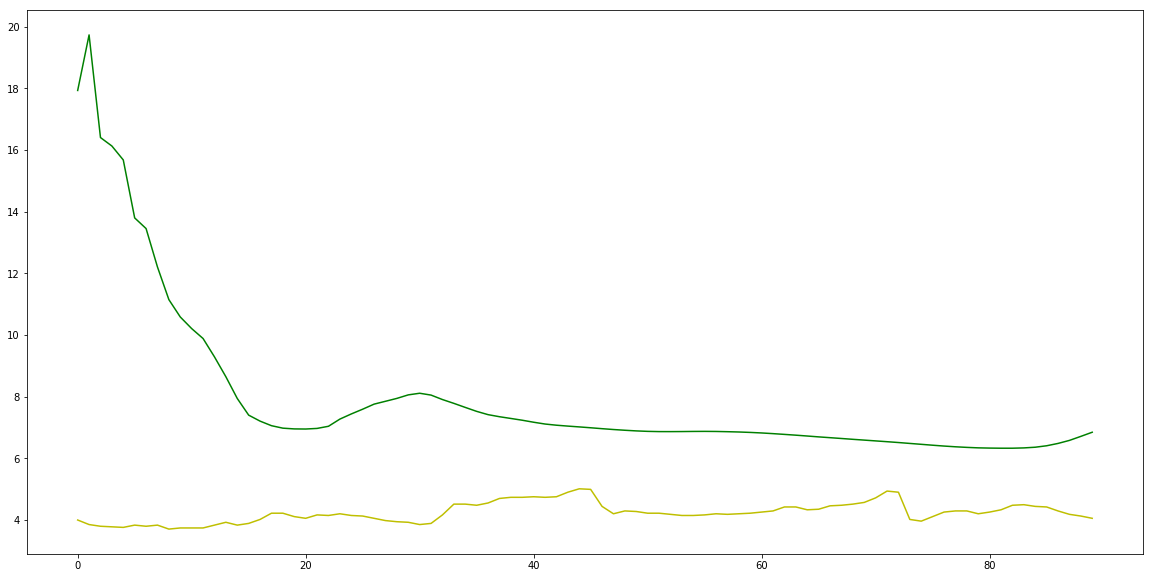

BBL


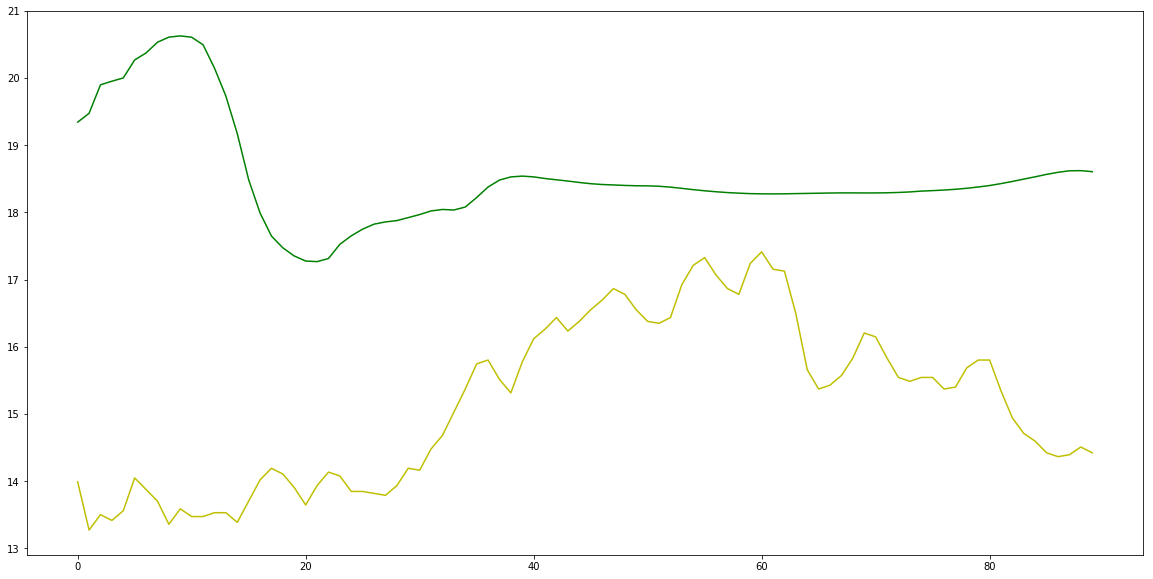

BCP


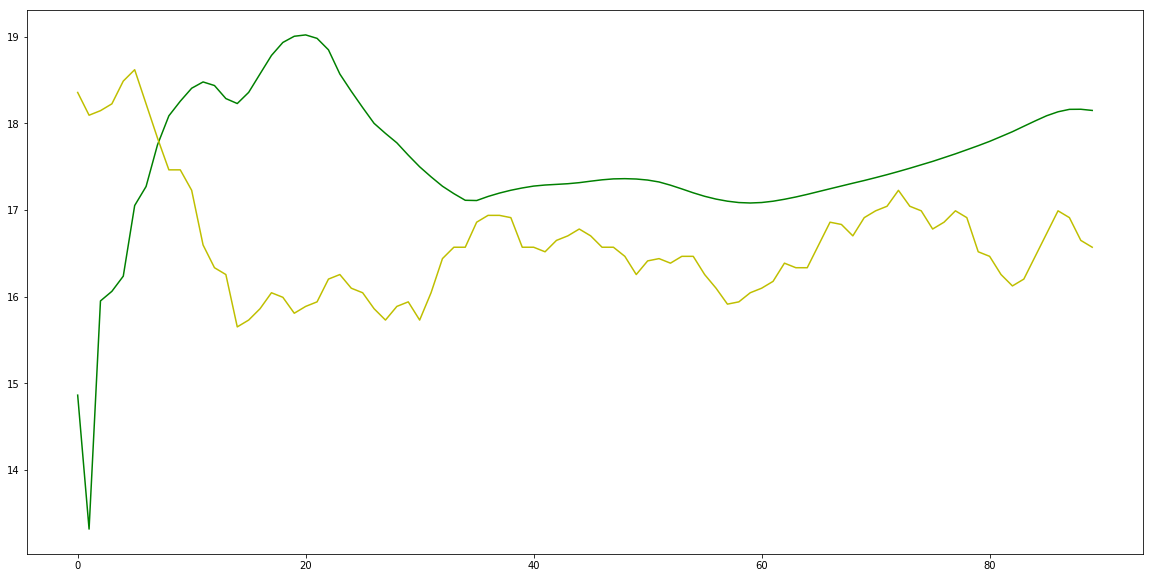

BDMS


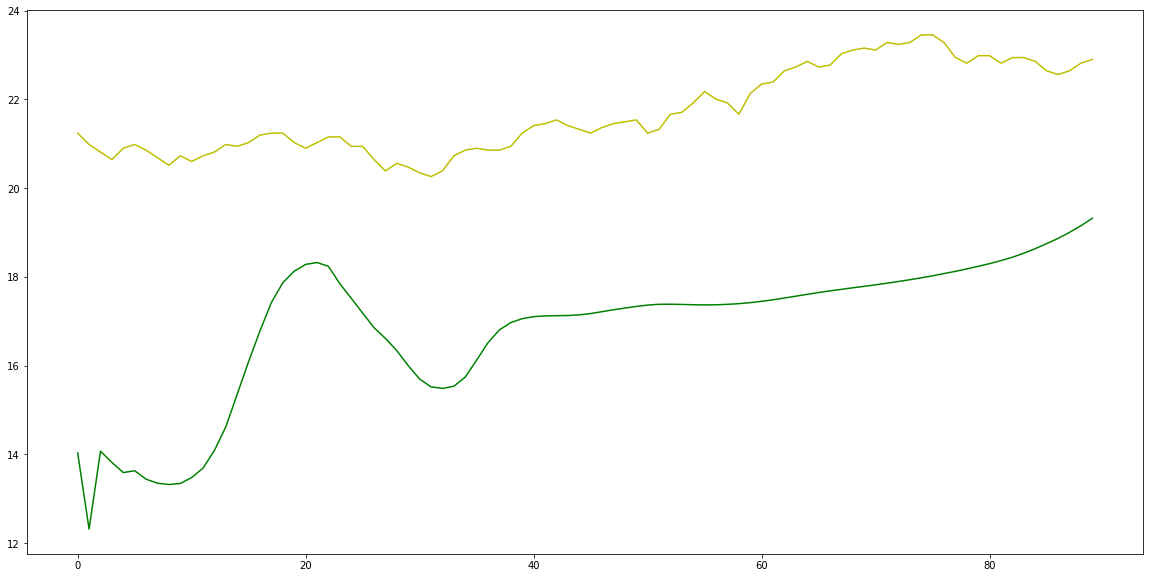

BEM


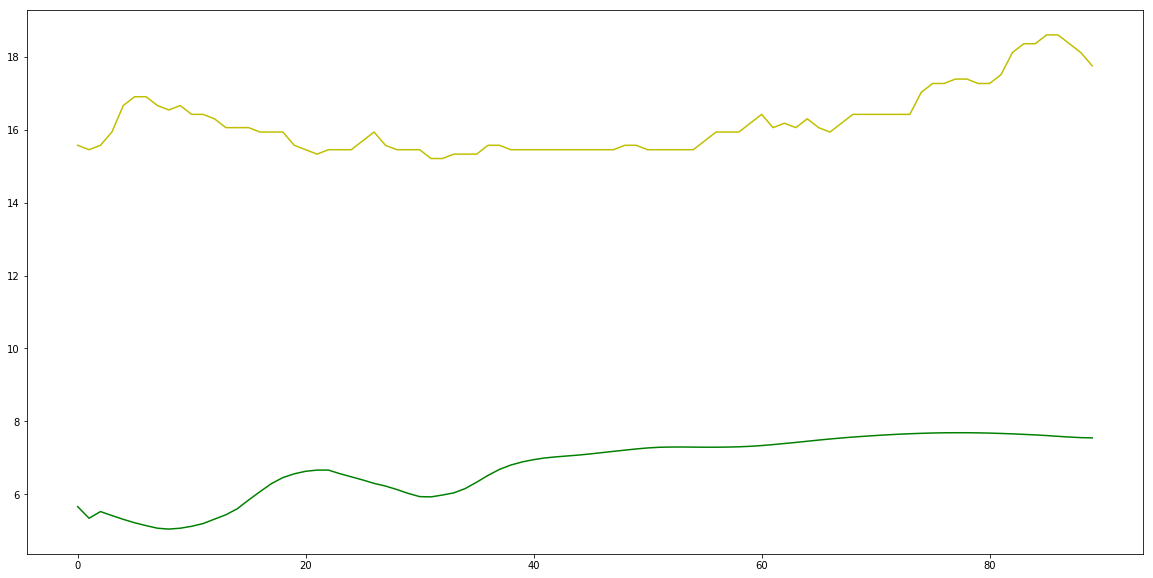

BH


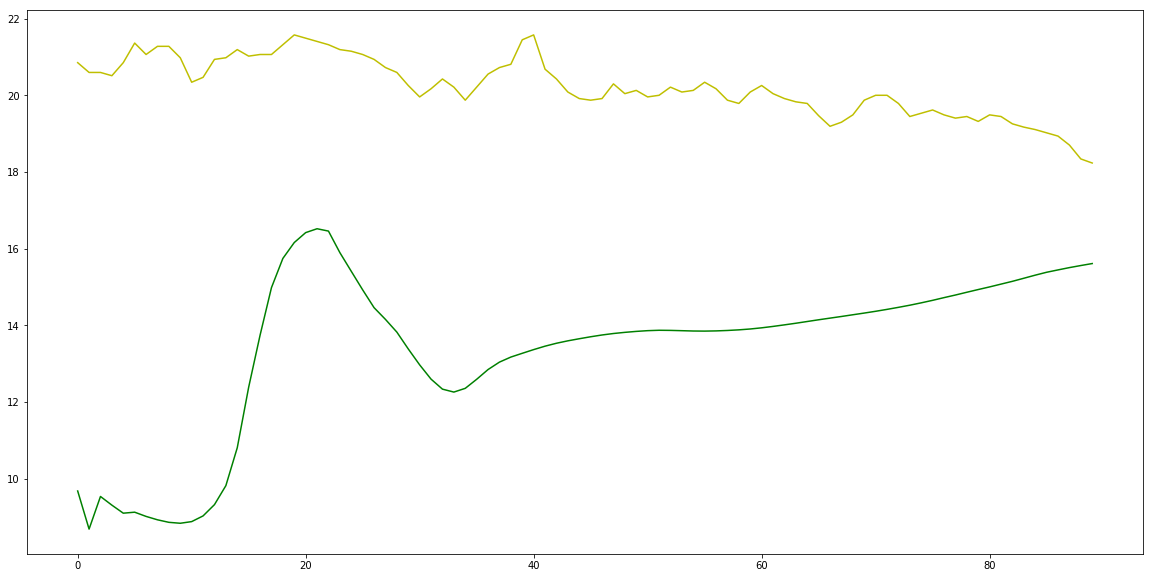

BJC


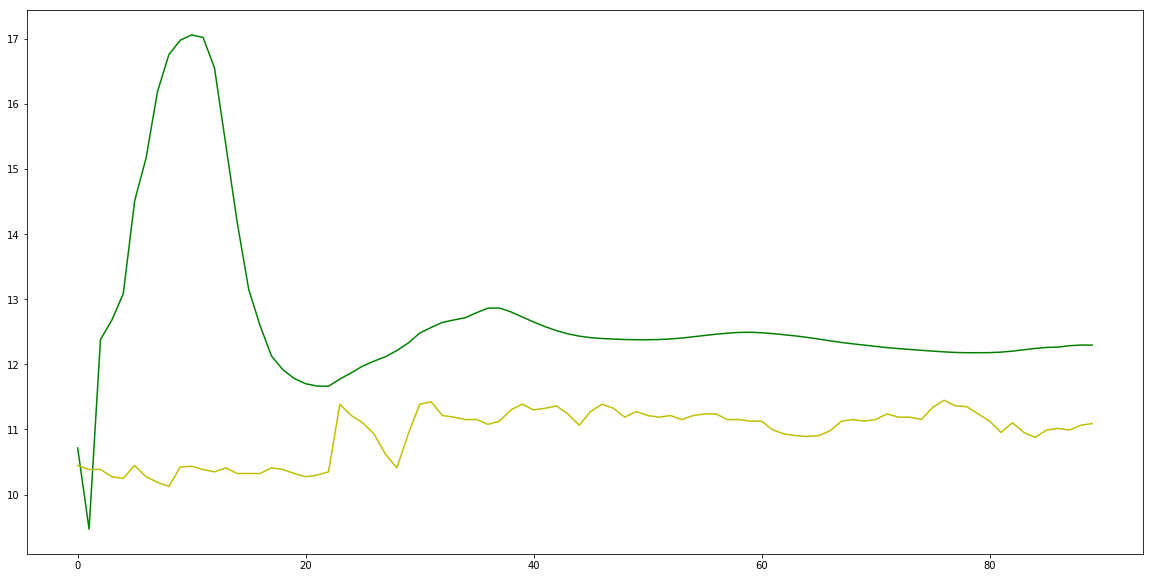

BTS


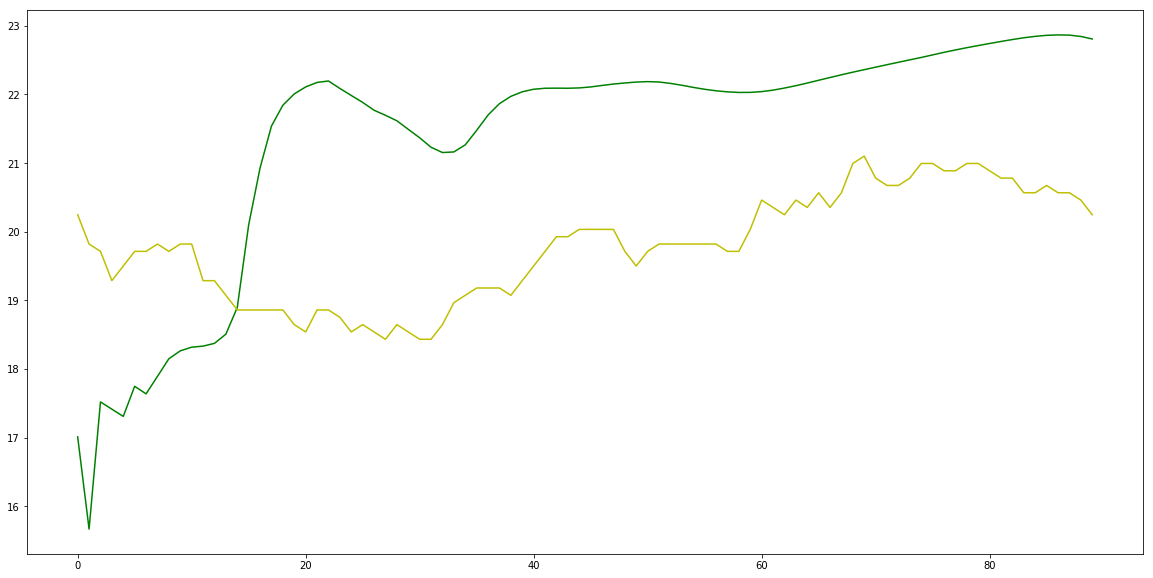

CENTEL


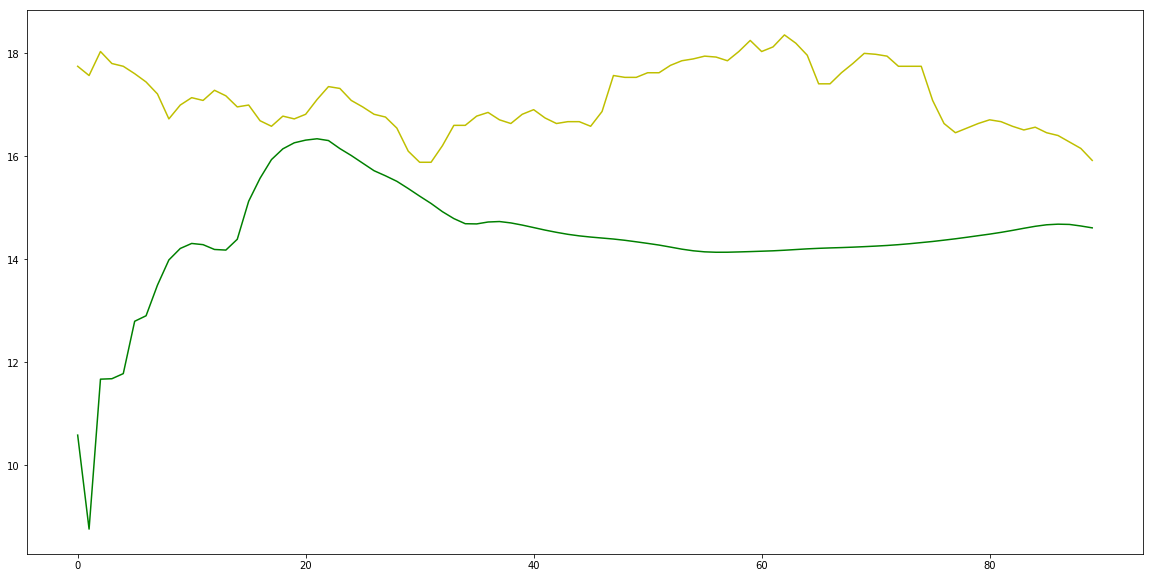

CPALL


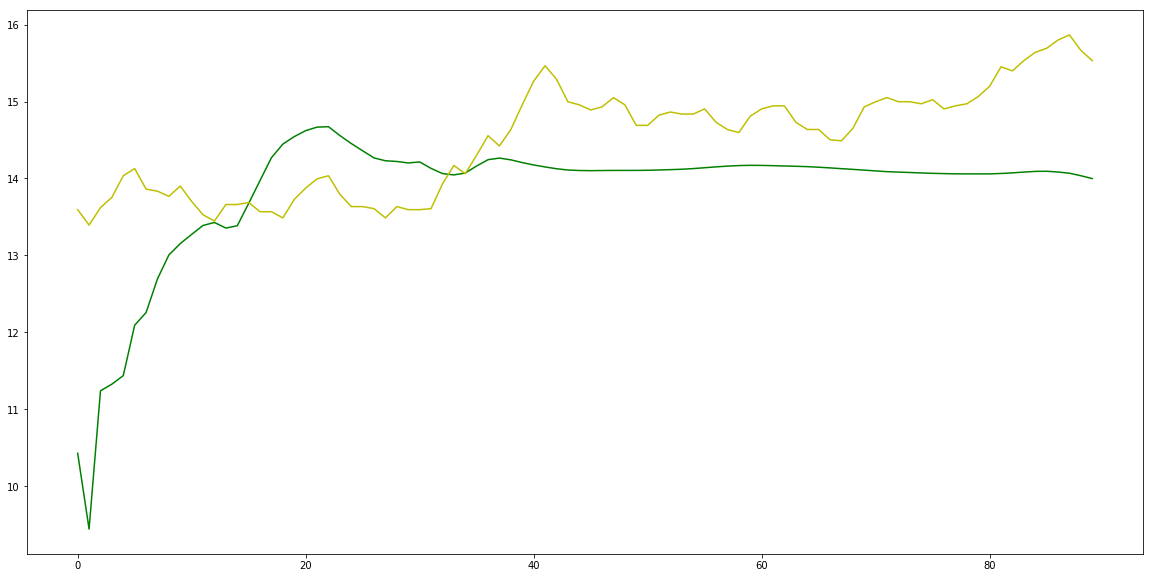

CPF


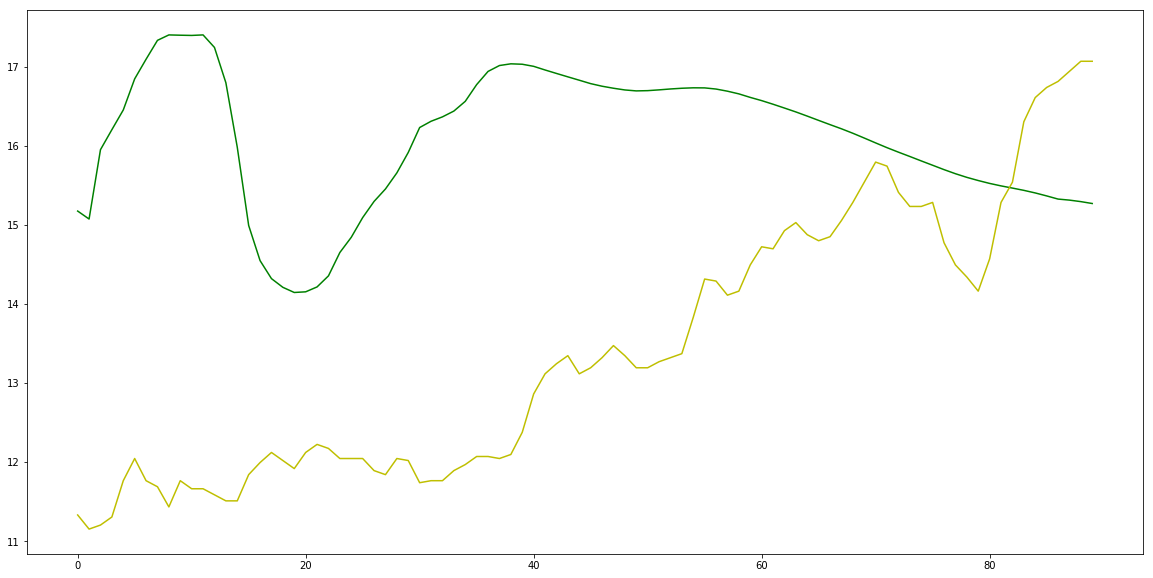

CPN


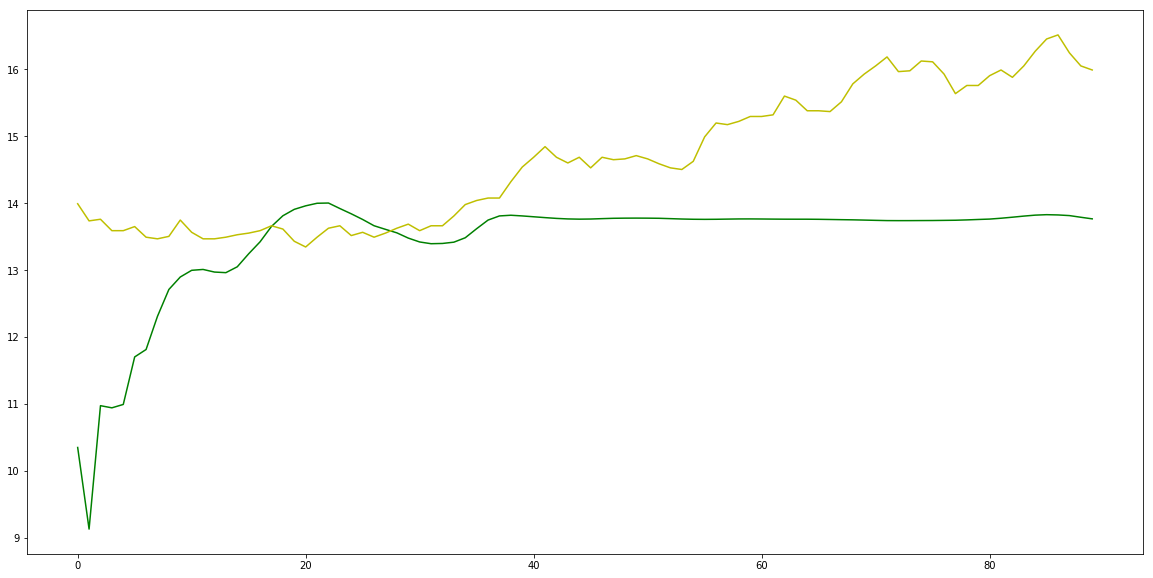

DTAC


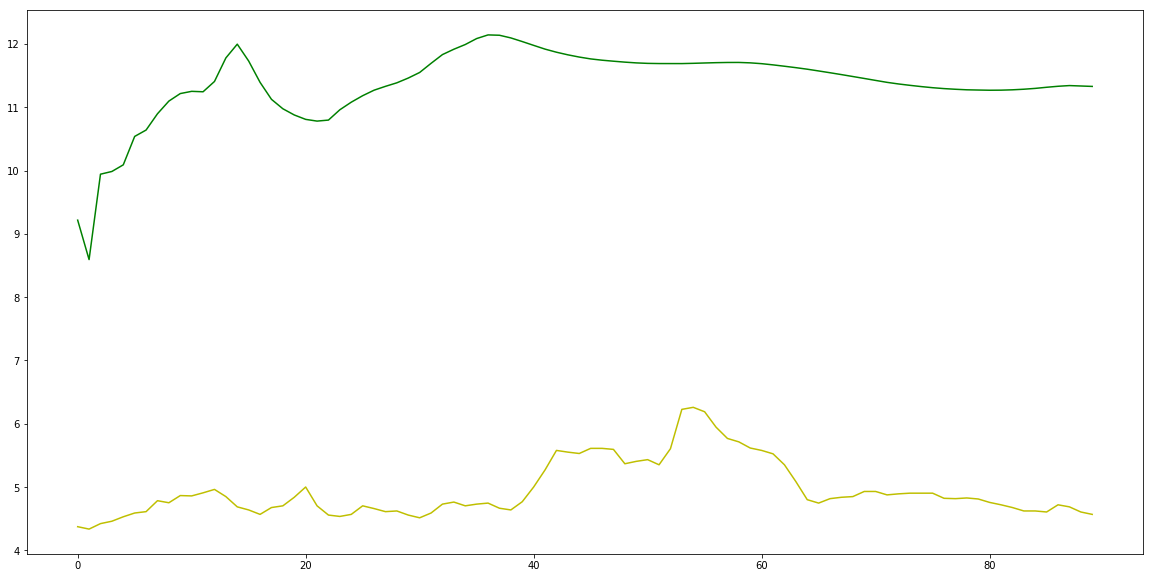

EGCO


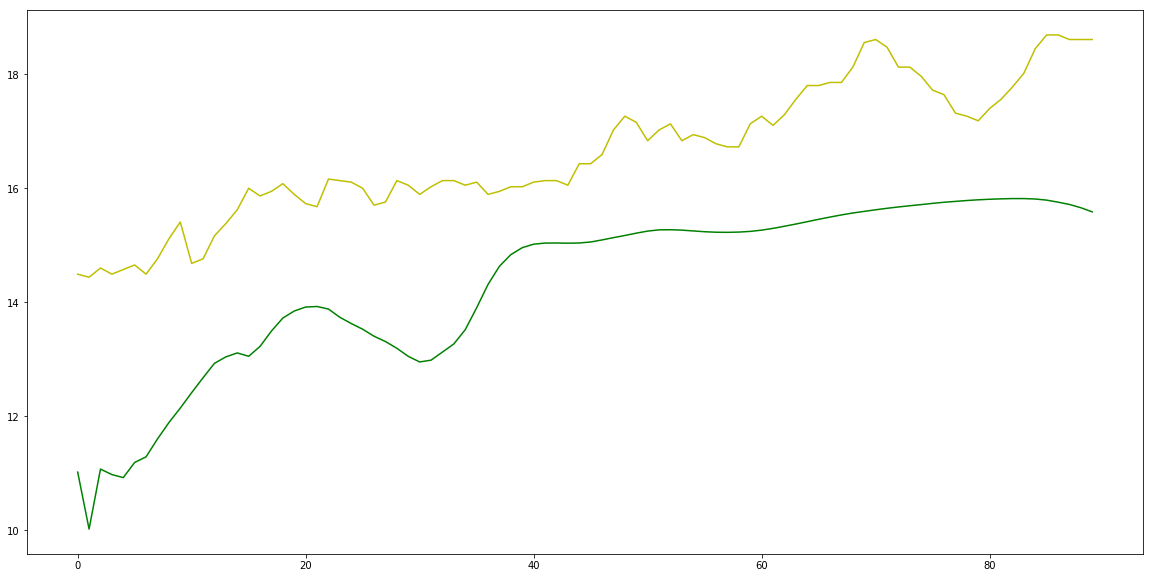

HMPRO


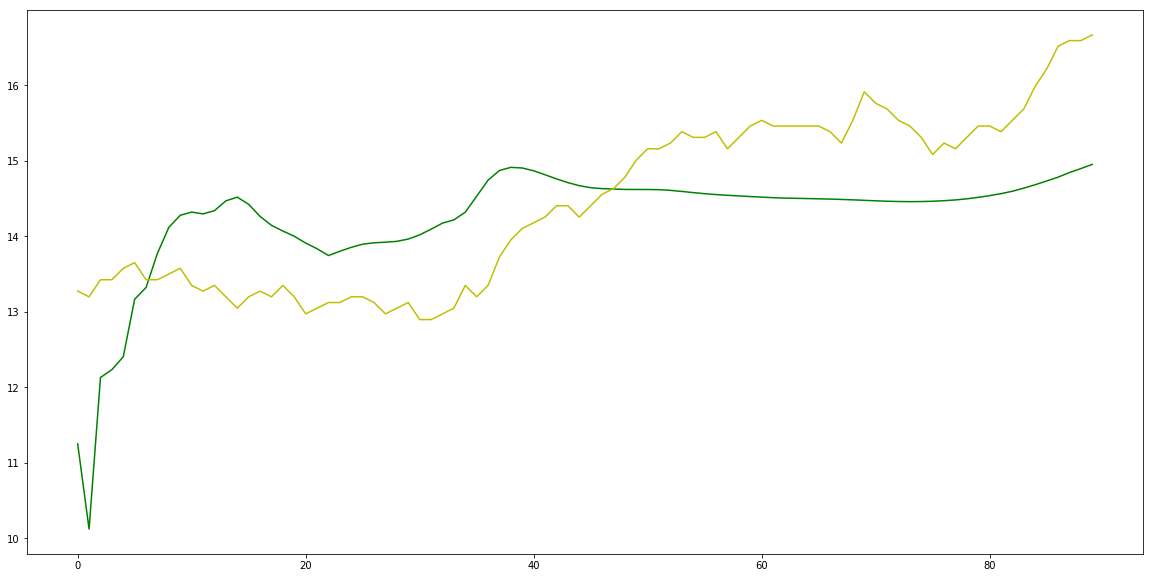

INTUCH


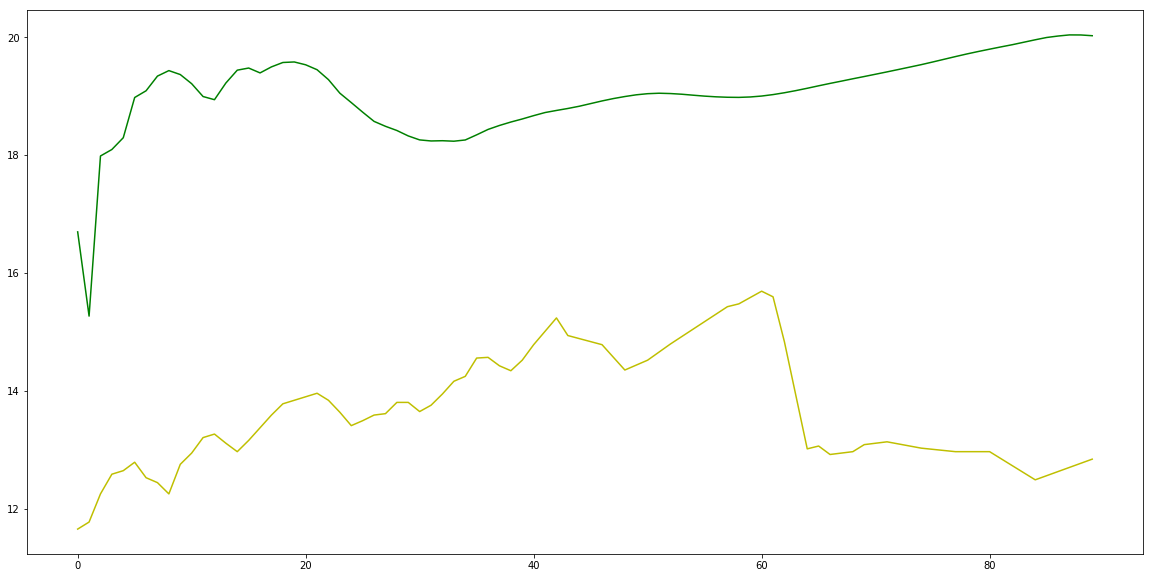

IRPC


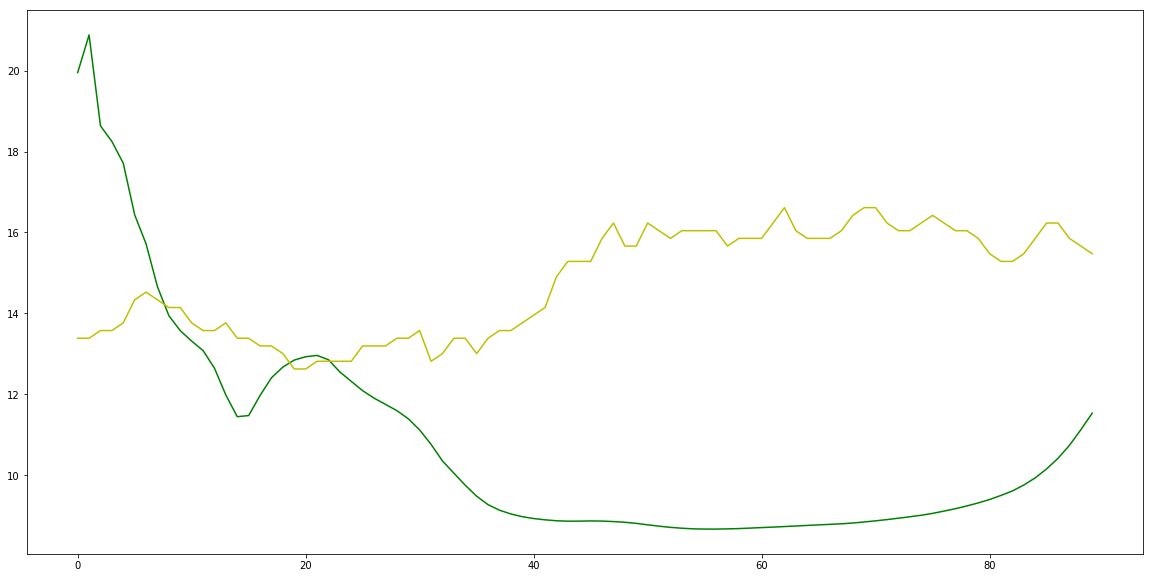

KBANK


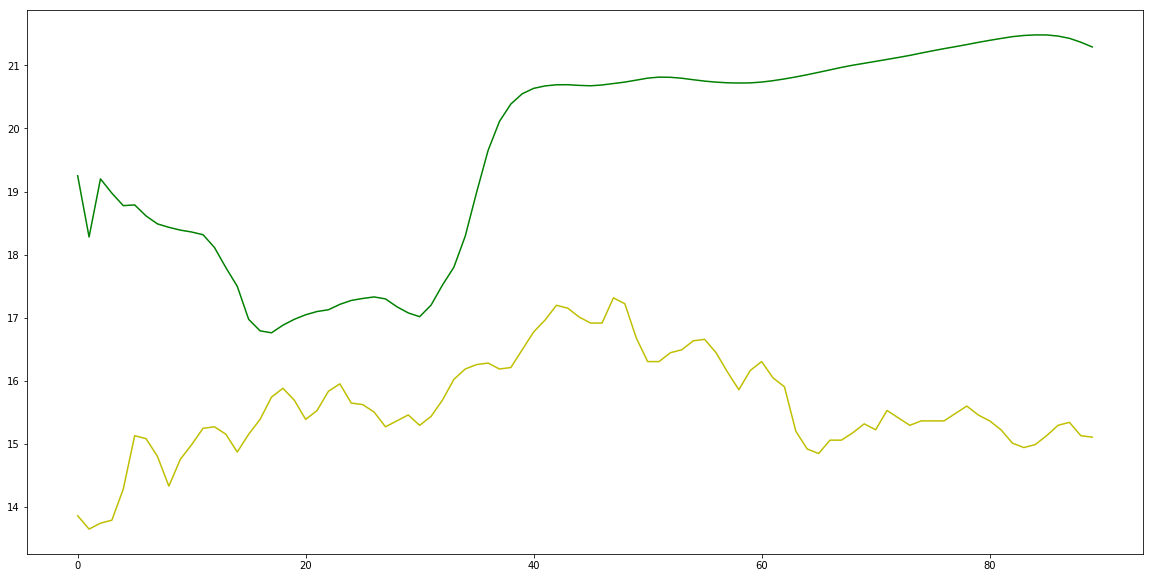

KCE


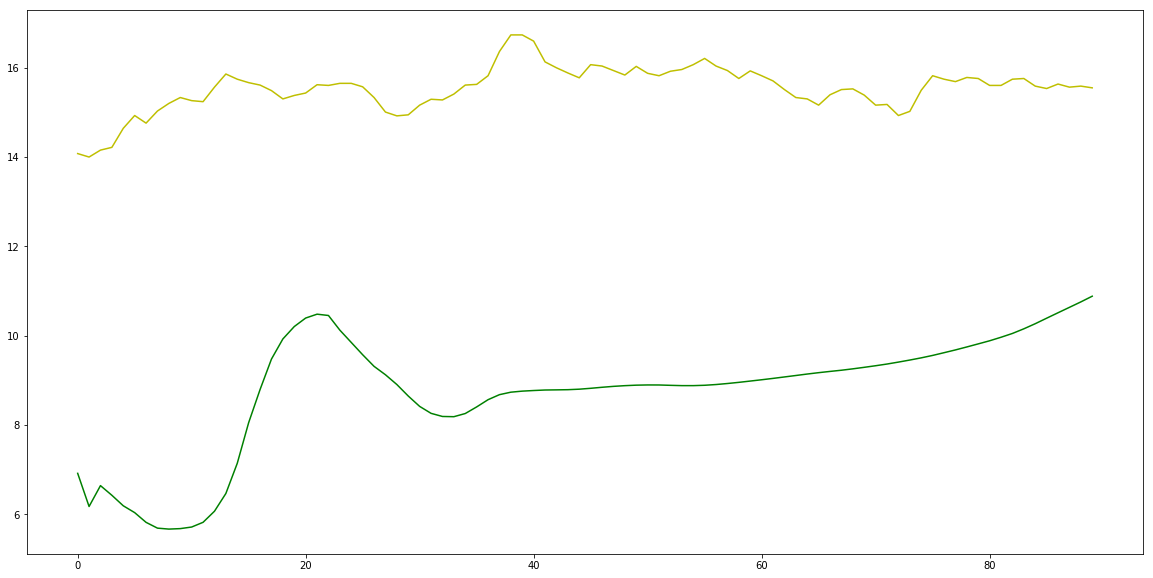

KKP


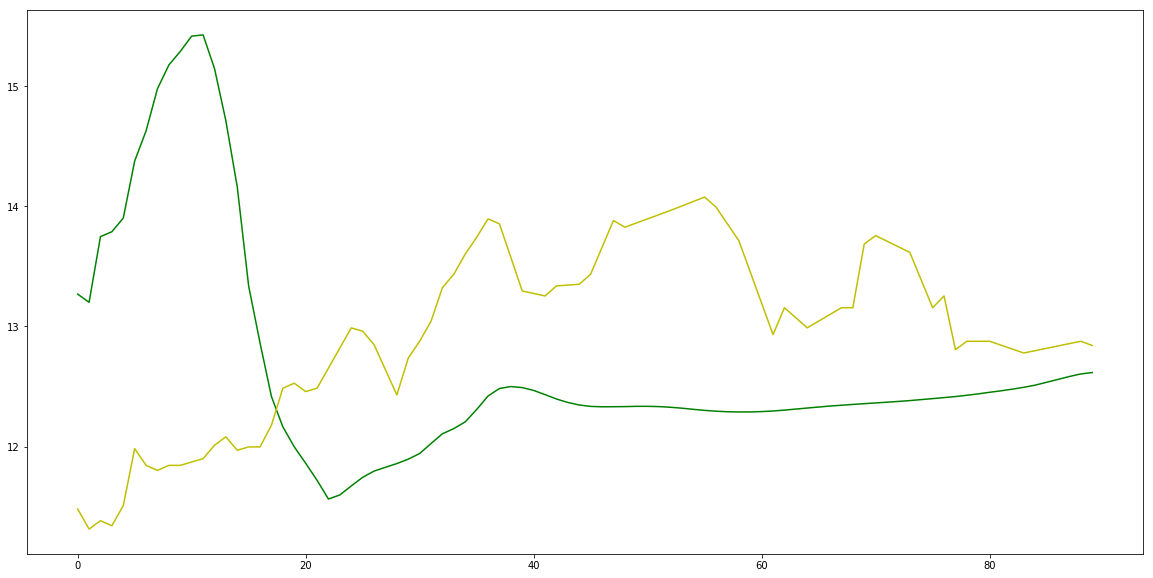

KTB


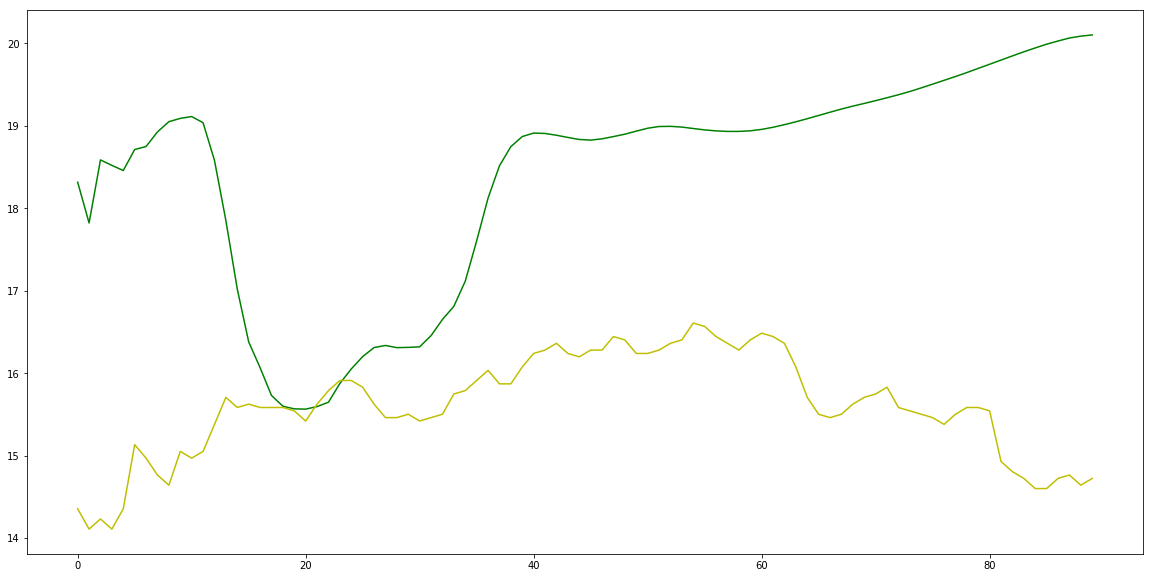

LH


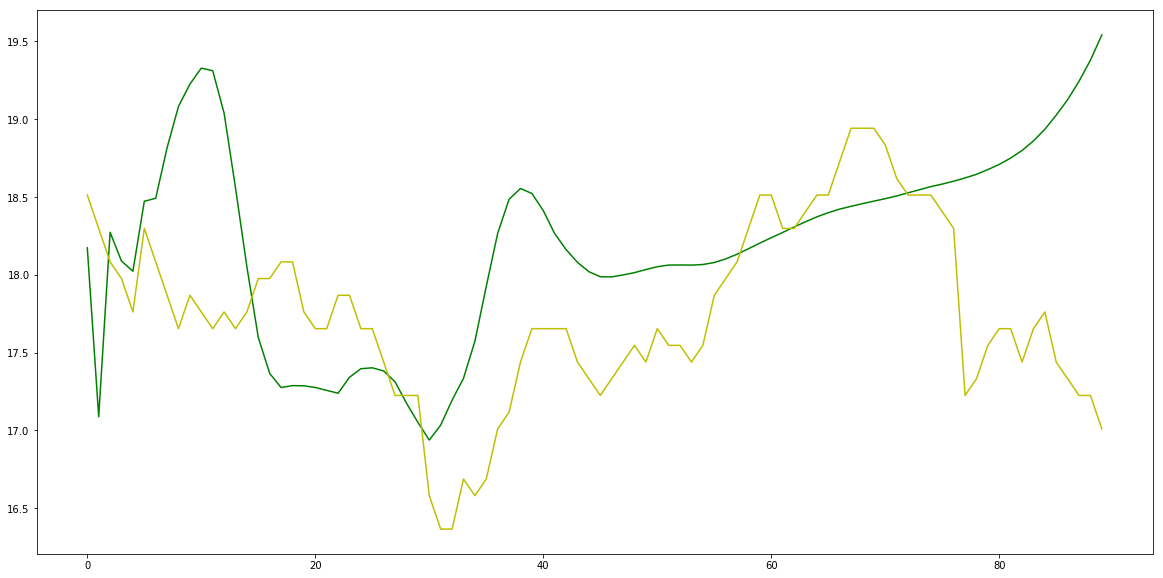

MINT


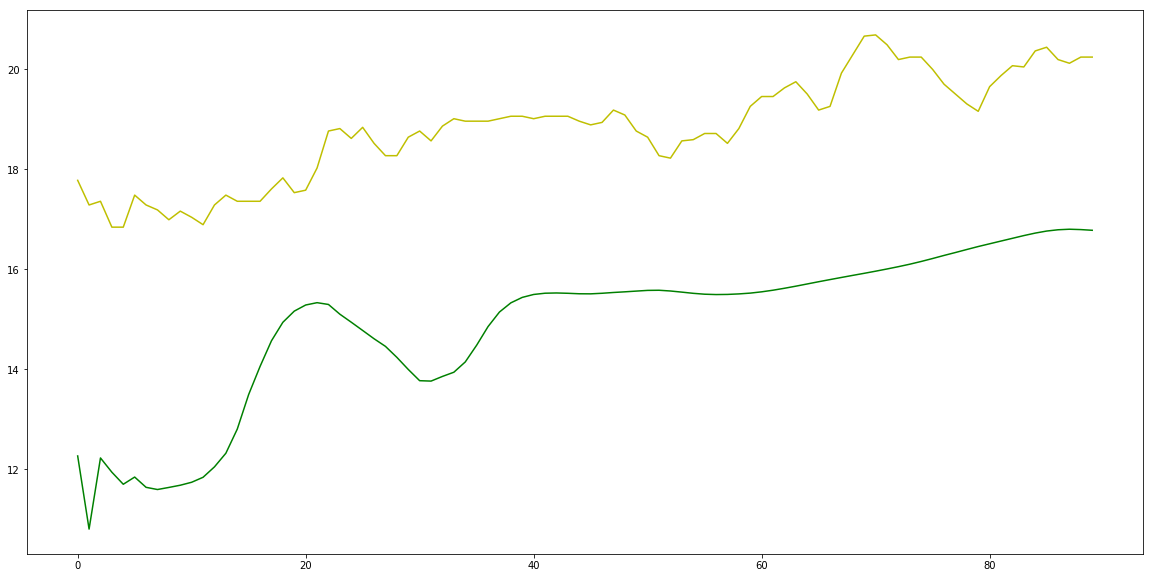

PTT


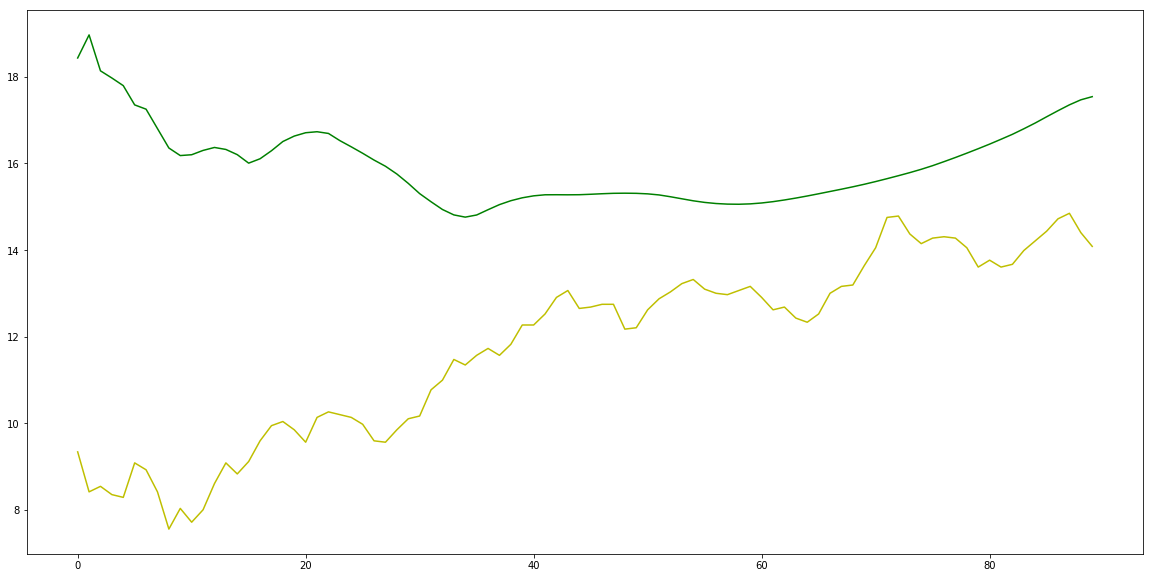

PTTEP


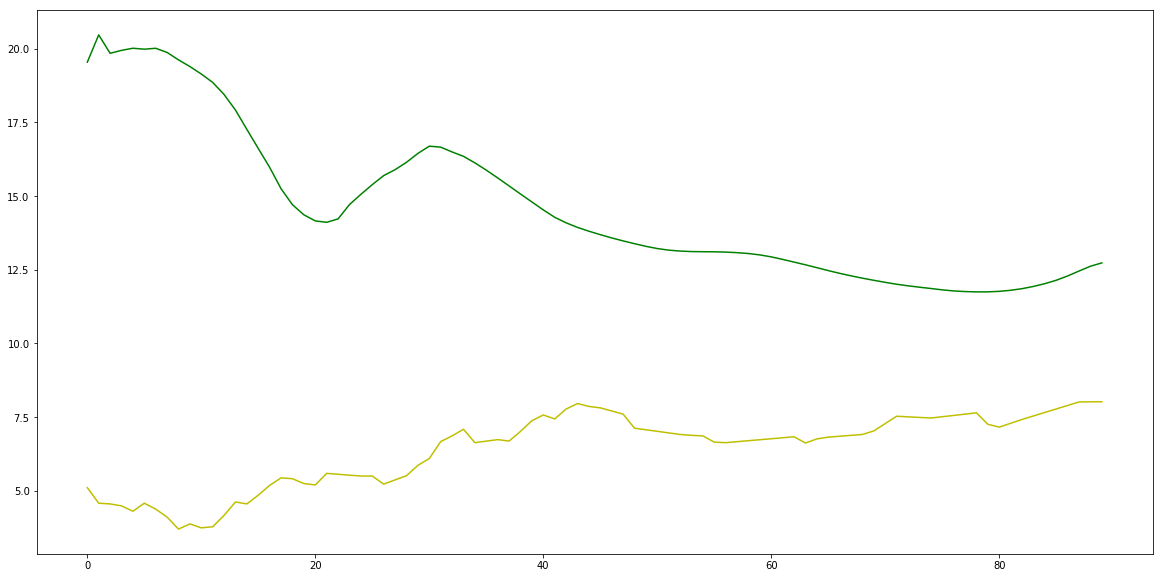

ROBINS


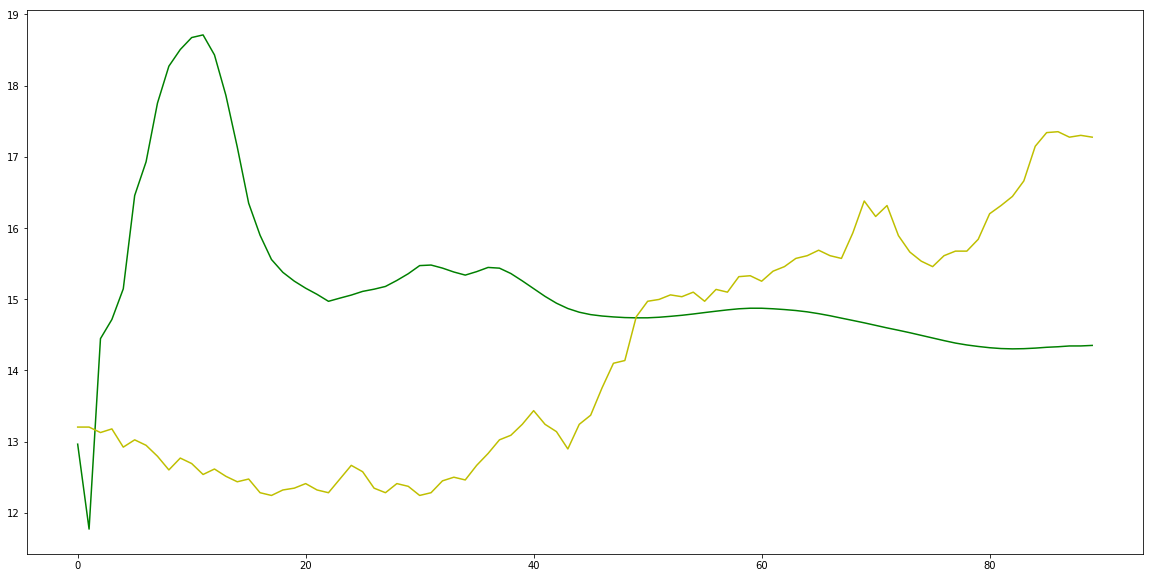

SCB


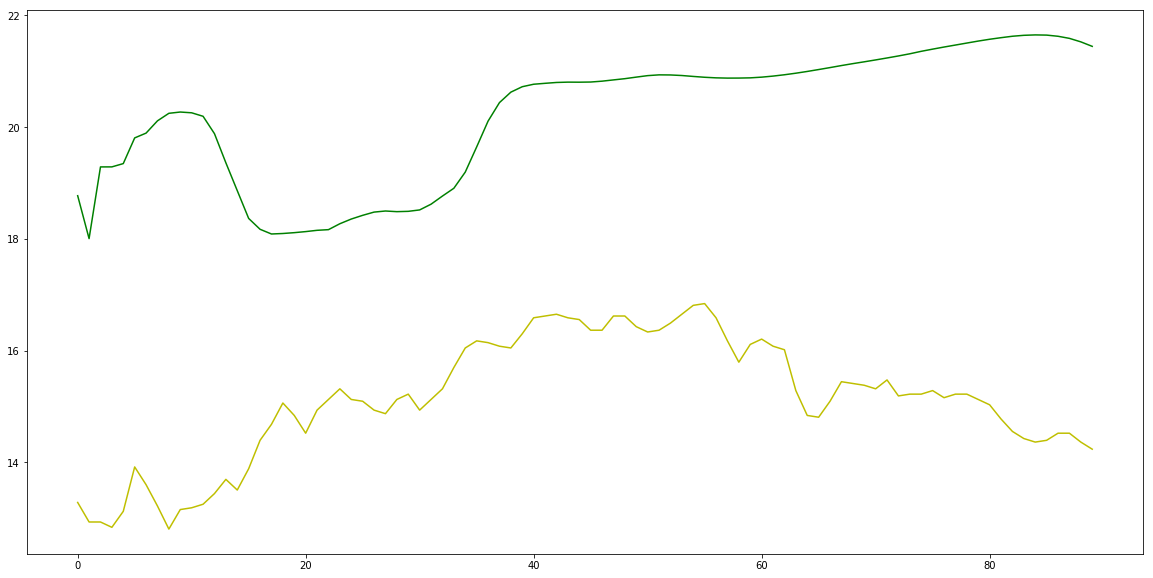

SCC


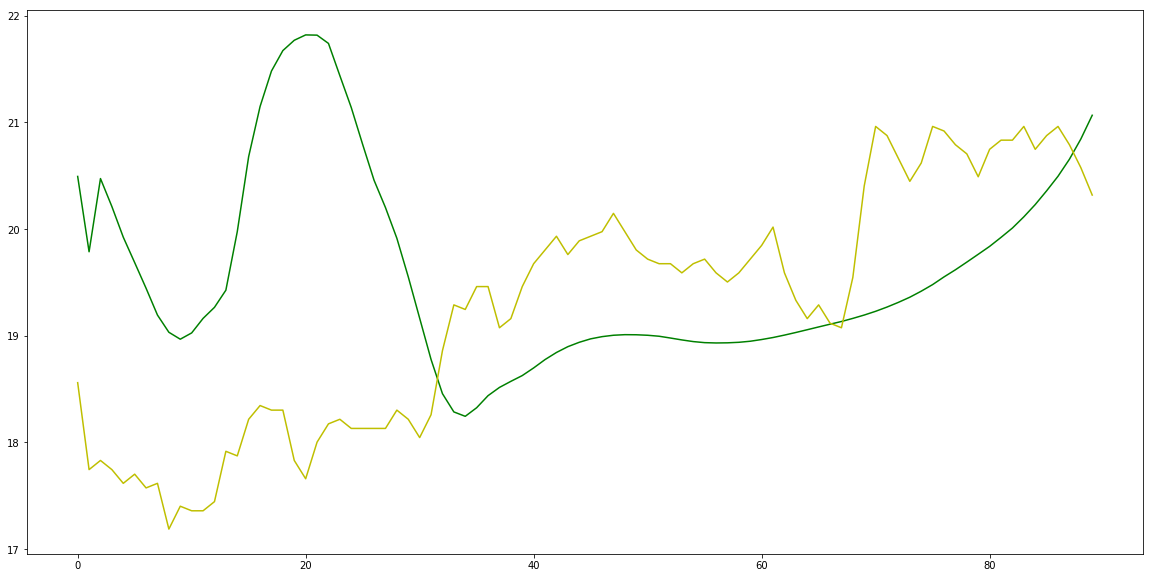

TCAP


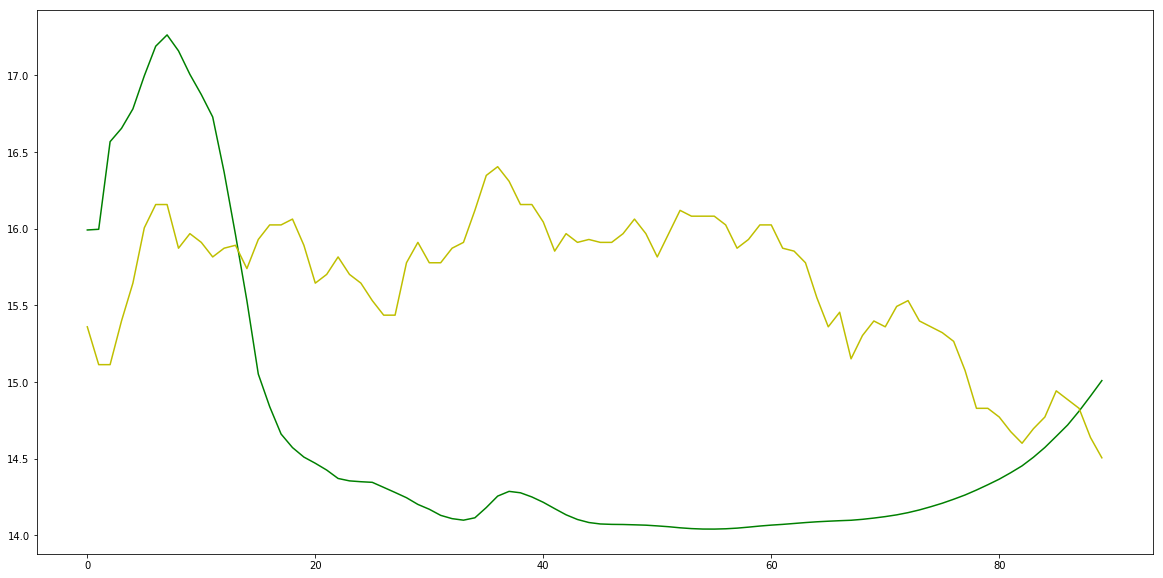

TISCO


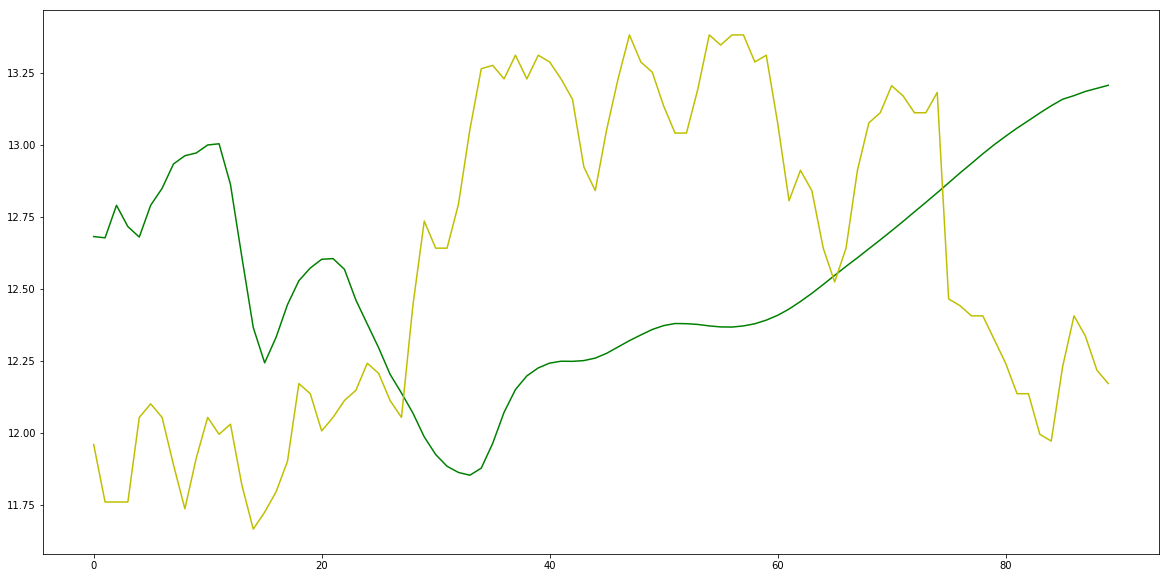

TMB


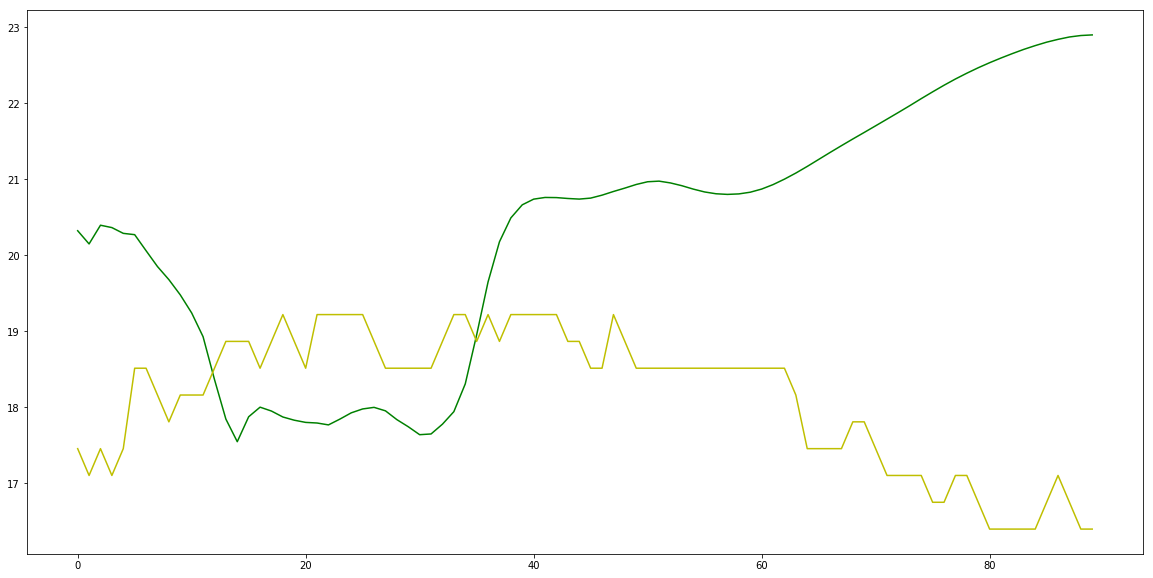

TOP


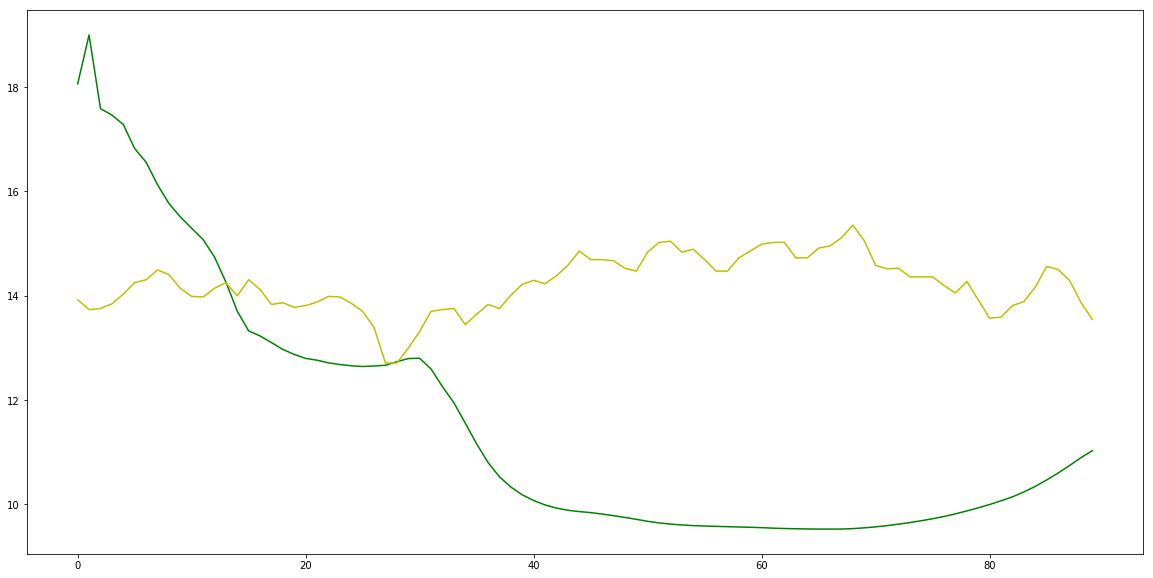

TRUE


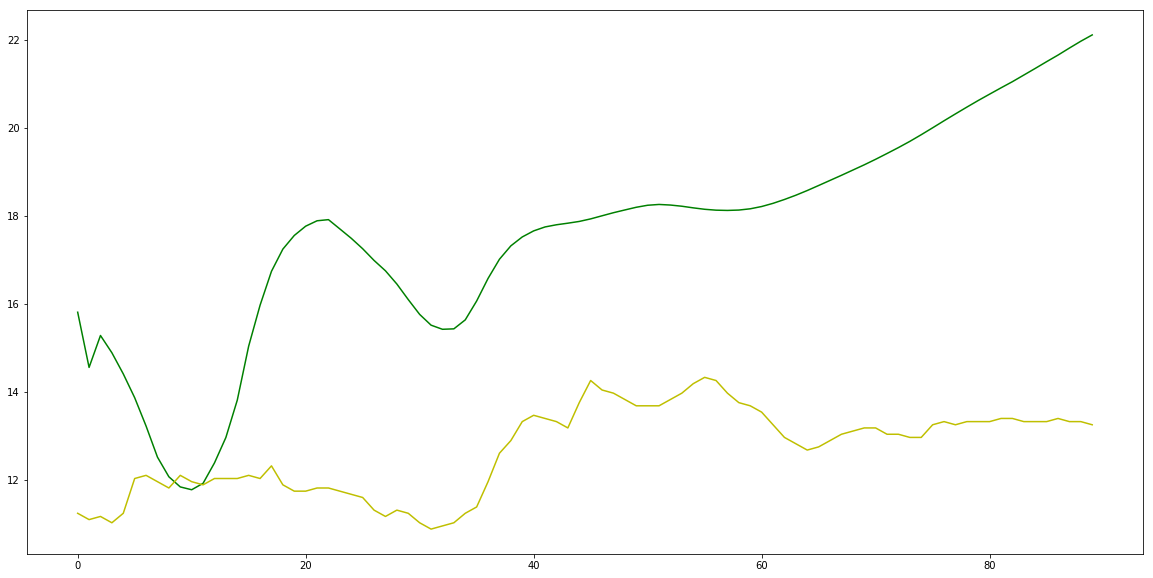

TU


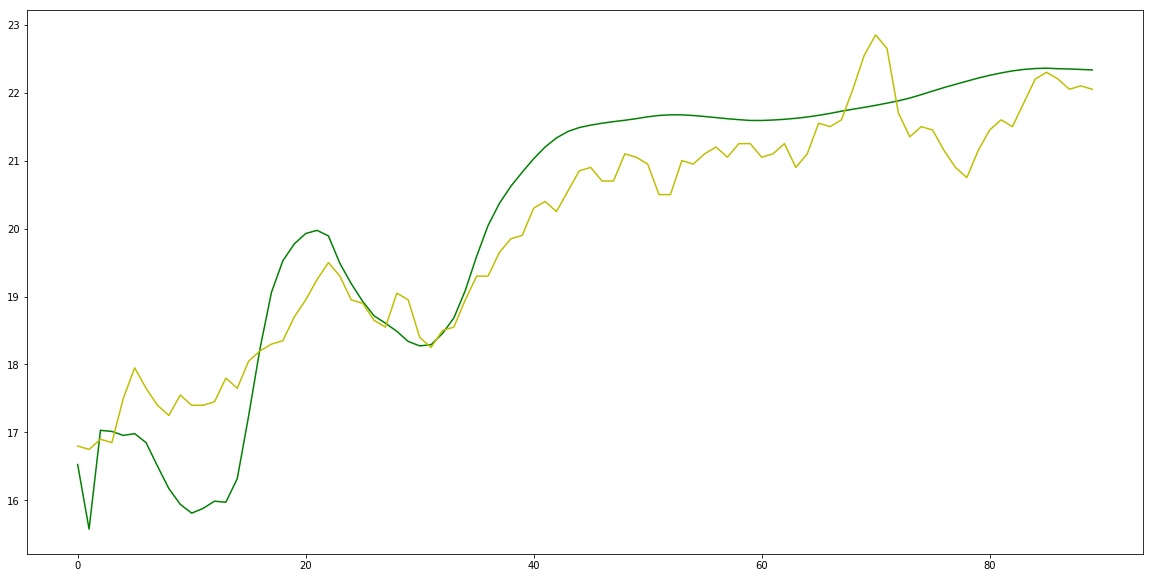

In [164]:
for i in range(len(SET50)):
    print(SET50[i])
    data1 = get_data_from_nparray(scaler.inverse_transform(predicts[0: 90]), i)
    data4 = get_data_from_nparray(scaler.inverse_transform(y_test[0: 90]), i)
    plot_graph(data1, data4)

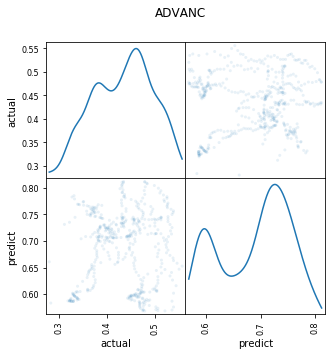

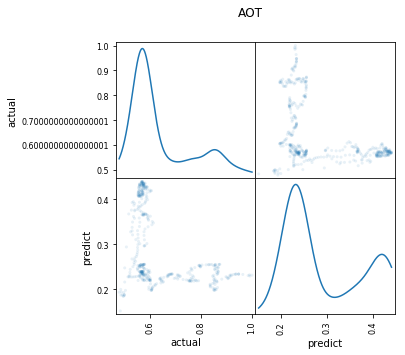

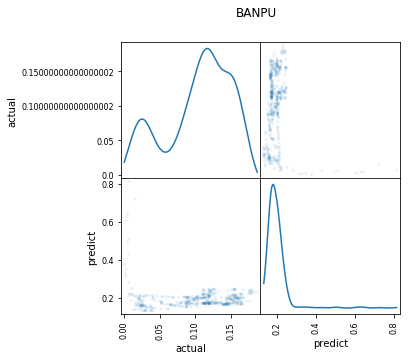

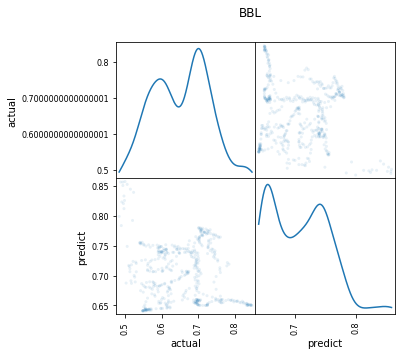

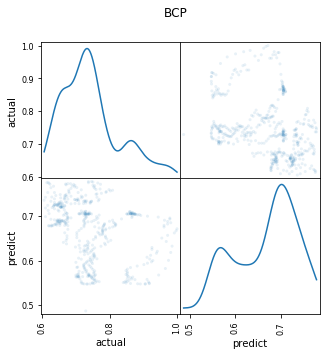

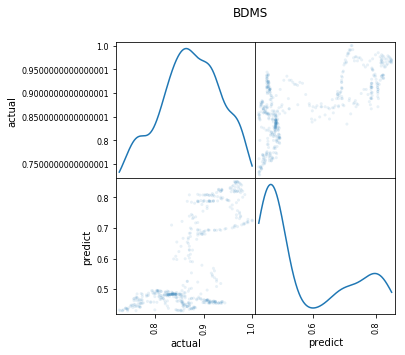

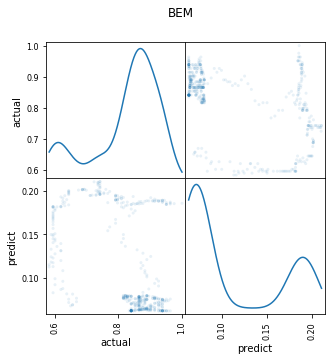

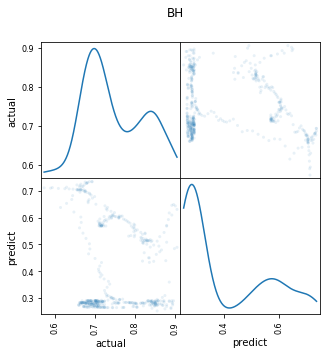

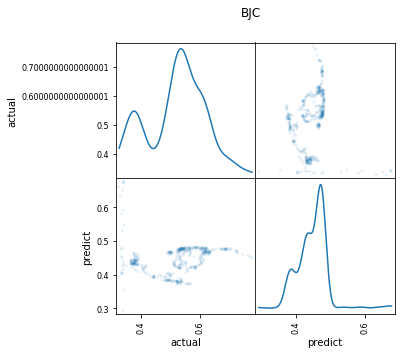

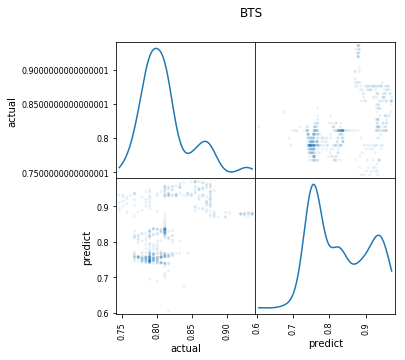

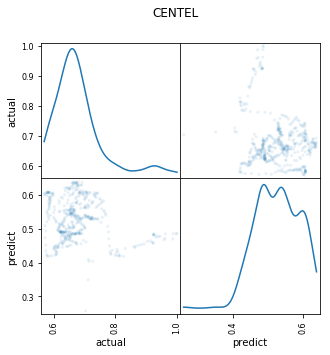

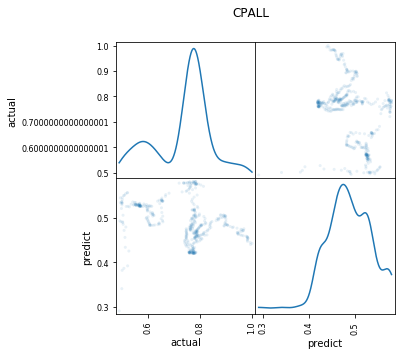

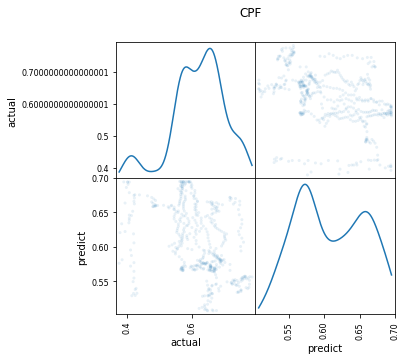

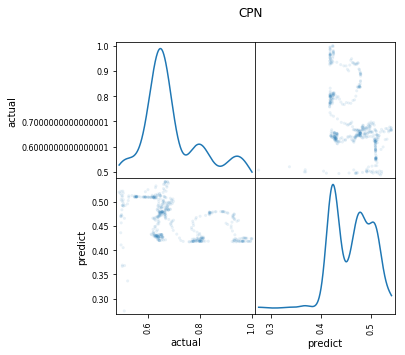

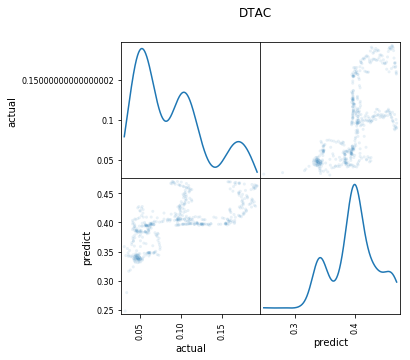

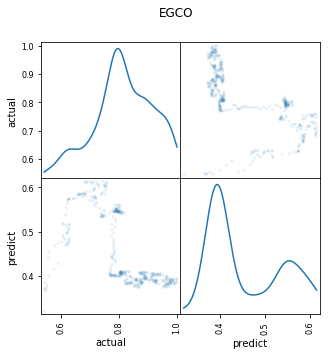

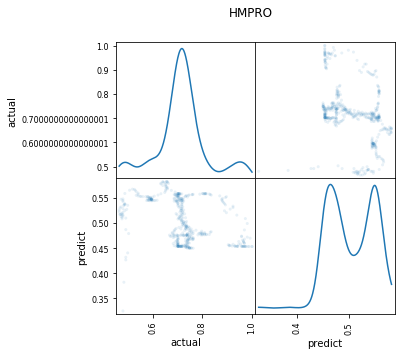

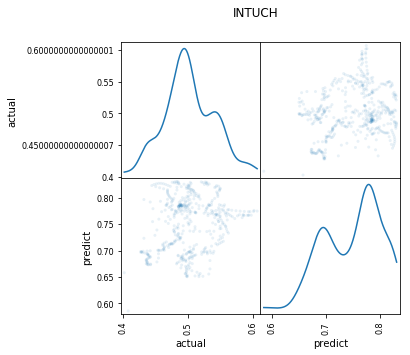

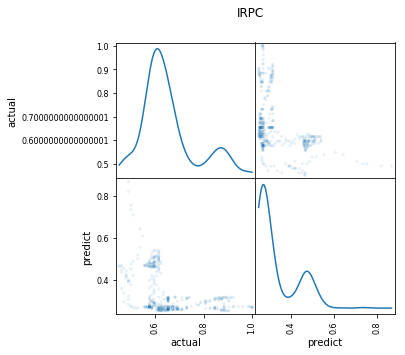

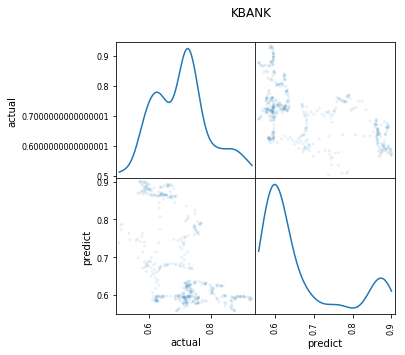

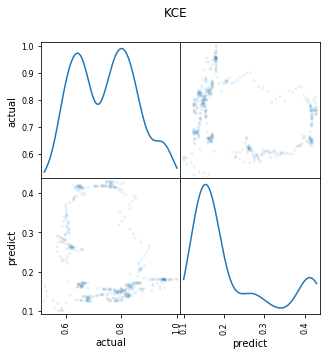

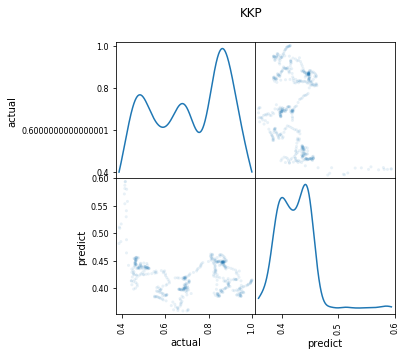

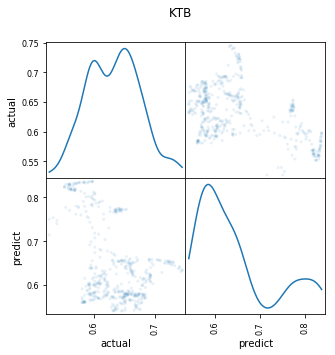

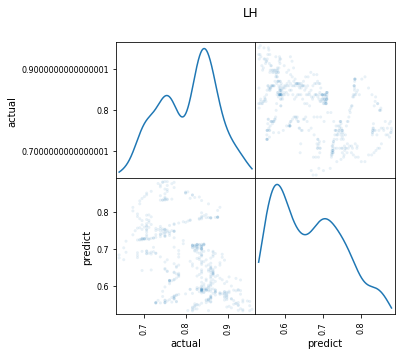

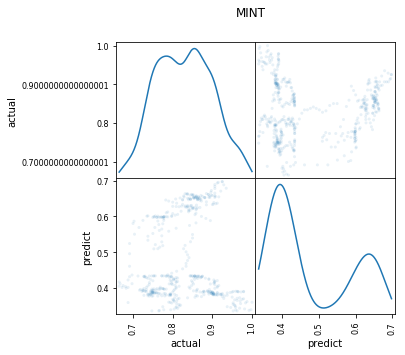

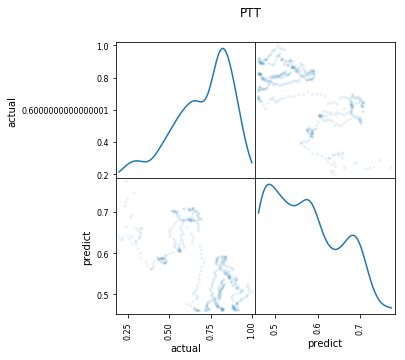

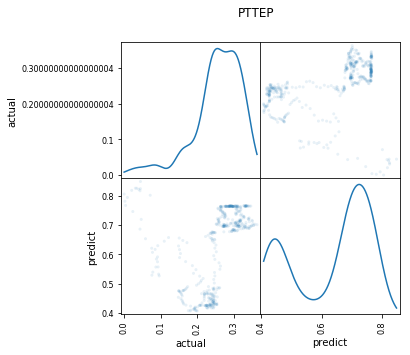

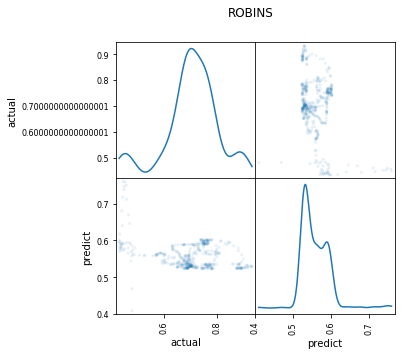

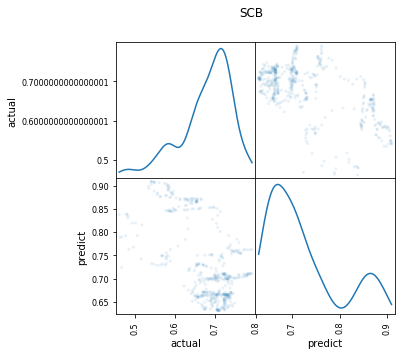

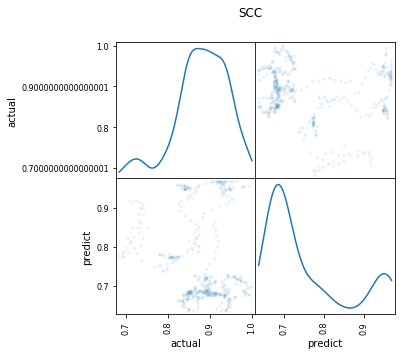

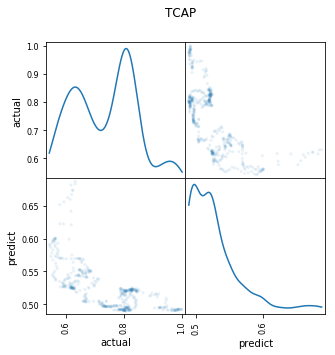

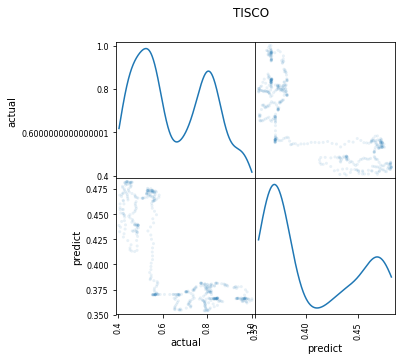

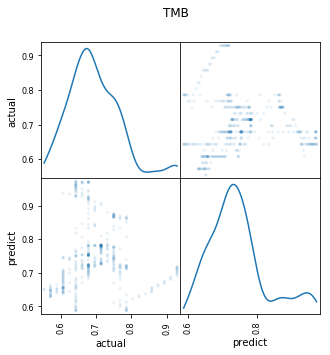

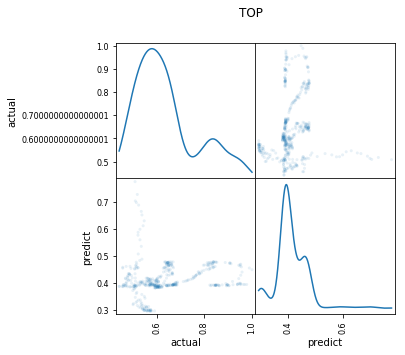

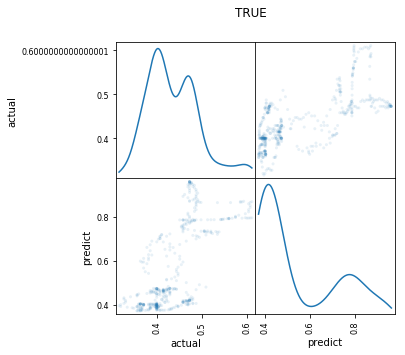

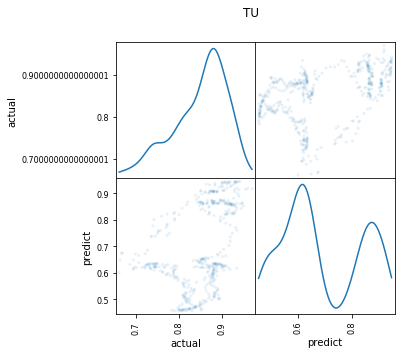

In [117]:
for i in range(len(SET50)):
    d = {'actual': get_data_from_nparray(y_test,i), 'predict': get_data_from_nparray(predicts,i)}
    df = pd.DataFrame(data=d)
    pd.plotting.scatter_matrix(df, diagonal='kde', alpha=0.1,figsize=(5,5))
    plt.suptitle(SET50[i])
    plt.show()